## Прогнозирование коэффициента восстановления золота из руды

Задача: по данным с параметрами добычи и очистки подготовить прототип модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды. </br>
</br>
Модель поможет оптимизировать производство, чтобы не запускать процессы с убыточными характеристиками.</br>
</br>
**План работы:**
</br>
- изучение и предобработка данных
- исследовательский анализ данных
- отбор и подготовка признаков
- обучение модели
- финальное тестирование

### Описание технологического процесса

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

**Флотация**</br>
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.</br>
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).</br>
**Очистка**</br>
Черновой концентрат проходит две очистки - первичную и вторичную. На выходе получается финальный концентрат и новые отвальные хвосты.</br>
</br>
</br>
Для решения задачи нам доступны данные об исходом и "исходящем" сырье на каждом этапе, применённых флотационных реагентах, флотационных хвостах, параметрах установок, используемых для очистки, промежуточных расчётах. Данные содержатся в трёх файлах - обучающая выборка, тестовая выборка и полная выборка, представляющая собой исходную выгрузку данных.

In [4]:
#для начала импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
from scipy import stats as st
import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.dummy import DummyRegressor

In [5]:
#определим константы 

RANDOM_STATE = 25

In [6]:
#откроем файл с данными

try:
    df_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
except FileNotFoundError:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

## Изучение и предобработка данных

### Предварительное знакомство с данными

Изучим доступные для решения задачи признаки и разберёмся, как каким этапам золотообогатительного процесса они относятся.

In [7]:
#первые пять строк датасета на примере df_full

df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
#выведем информацию о каждом датасете

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

**Нам доступны:** </br>
- тренировочный набор данных 5290 записей и 53 признаков
- тестовый набор данных 14149 записей и 87 признаков
- полный набор данных 19439 записей и 87 признаков
</br>
Все признаки, кроме даты - тип float. В данных есть пропуски - в том числе в тестовом наборе. Для дальнейшей работы их необходимо будет обработать.</br>
</br>

**Что мы знаем о составляющих названий столбцов:**</br>
</br>
**rougher, primary_cleaner, secondary_cleaner** - названия трёх этапов: флотации (грубой очистки), первичной и вторичной очистки</br>
**final** - резульаты после окончания процесса</br>
**input и output** - "входящие" и "исходящие" параметры для каждого этапа</br>
**state** - метка "состояния", относится к обогатительным установкам</br>
**calculation** - признаки, которые были расчитаны, а не измерены</br>
**feed** - доля металла, в сырье, подаваемом на вход</br>
Есть также параметры **feed_size и feed_rate** - это размер гранул и скорость подачи</br>
**concentrate** - концентрация полезного материала после прохождения очередного этапа</br>
**tail** - отвал</br>
**ag, au, pb, sol** - серебро, золото, свинец, сопутствующий коллоид: вещества, концентрация которых характеризует процесс обогащения</br>
**xanthate, sulfate, depressant** - ксантат, сульфат и депрессант: химагенты, применяемые при обогащении</br>
**floatbank+метка** - обогатительная установка, с которой снимаются показания ее состояния </br>
**air и level** - показания, снимаемые с флотационных установок и означающие уровень подачи воздуха и жидкости</br>
</br>
Целевые признаки, которые необходимо предсказать:</br>
**rougher.output.recovery** - эффективность обогащения после этапа грубой очистки</br>
**final.output.recovery** - финальная эффективность обогащения </br>

In [11]:
#проверим, что число записей между датасетами бьётся

14149 + 5290

19439

In [12]:
#проверяем дубликаты

df_full.duplicated().sum()

0

Посмотрим, чем различаются тренировочная и тестовая выборки

In [13]:
# формируем списки признаков

list_of_test_features = list(df_test.columns)
list_of_features = list(df_train.columns)

In [14]:
#находим признаки, которых нет в тесте

list_of_nontest_features = pd.Series(list(set(list_of_test_features) ^ set(list_of_features)))
display(list_of_nontest_features)

0                        primary_cleaner.output.tail_pb
1                                  final.output.tail_pb
2                                  final.output.tail_au
3                 primary_cleaner.output.concentrate_pb
4                                 final.output.tail_sol
5                         rougher.output.concentrate_pb
6                               rougher.output.tail_sol
7                           final.output.concentrate_ag
8                     secondary_cleaner.output.tail_sol
9                           final.output.concentrate_au
10    rougher.calculation.floatbank10_sulfate_to_au_...
11                       rougher.output.concentrate_sol
12                               rougher.output.tail_au
13                      primary_cleaner.output.tail_sol
14                                 final.output.tail_ag
15                primary_cleaner.output.concentrate_ag
16                              rougher.output.recovery
17                         final.output.concentr

Эти признаки, как видим, относятся к колонкам output, т.е. результатам после прохождения очередного этапа. Так же в этот список попали данные калькуляции, которая, видимо, делается после этапа.</br> 
Очевидно, что до начала процесса эти данные недоступны и, видимо, в тестовой выборке мы видим те данные, которые известны до запуска процесса. В список тестовых параметров также попали состояния флотационных установок (---.state.floatbank---air и ---.state.floatbank---level) - вероятно, это задаваемые параметры установок, а не показания датчиков в процессе обогащения. </br>
</br>

**Подытожим:** нам известны параметры входного сырья и реагентов для каждого этапа, а также входные параметры обогатительных/флотационных установок. Т.е. по соотношению веществ, размеру, скорости подачи и состоянию установок нам нужно предсказать возможности обогащения. </br>
Результаты обогащения и сопутствующие показания, естетственно, неизвестны в реальном процессе, однако есть в виде исторических данных, по которым мы можем вытащить полезную для обучения модели информацию. 

### Таблица признаков обогатительного процесса (по историческим данным)
Зелёным цветом помечены признаки, доступные до начала процесса (тестовая выборка). </br>
Жёлтым - целевые признаки.

|       | Input | Output | State | Calculation |
| :- | :-: | :-: | :-: | :-: |
| Flotation | <div class="alert alert-block alert-success"> rougher.input.feed_ag <br> rougher.input.feed_pb <br> rougher.input.feed_rate <br>rougher.input.feed_size <br>     rougher.input.feed_sol <br> rougher.input.feed_au <br> rougher.input.floatbank10_sulfate <br>      rougher.input.floatbank10_xanthate <br> rougher.input.floatbank11_sulfate <br> rougher.input.floatbank11_xanthate | rougher.output.concentrate_ag <br> rougher.output.concentrate_pb <br> rougher.output.concentrate_sol <br> rougher.output.concentrate_au  <br> <div class="alert alert-block alert-warning"><b> rougher.output.recovery </b></div>  <br> rougher.output.tail_ag <br> rougher.output.tail_pb <br> rougher.output.tail_sol <br> rougher.output.tail_au </div>| <div class="alert alert-block alert-success"> rougher.state.floatbank10_a_air <br> rougher.state.floatbank10_a_level <br> rougher.state.floatbank10_b_air <br> rougher.state.floatbank10_b_level <br> rougher.state.floatbank10_c_air <br> rougher.state.floatbank10_c_level <br> rougher.state.floatbank10_d_air <br> rougher.state.floatbank10_d_level <br> rougher.state.floatbank10_e_air <br> rougher.state.floatbank10_e_level <br> rougher.state.floatbank10_f_air <br> rougher.state.floatbank10_f_level  </div> | rougher.calculation.sulfate_to_au_concentrate <br> rougher.calculation.floatbank10_sulfate_to_au_feed <br> rougher.calculation.floatbank11_sulfate_to_au_feed <br> rougher.calculation.au_pb_ratio |
| Primary clean | <div class="alert alert-block alert-success">primary_cleaner.input.sulfate <br> primary_cleaner.input.depressant <br> primary_cleaner.input.feed_size <br> primary_cleaner.input.xanthate </div>| primary_cleaner.output.concentrate_ag <br> primary_cleaner.output.concentrate_pb <br> primary_cleaner.output.concentrate_sol <br> primary_cleaner.output.concentrate_au <br> primary_cleaner.output.tail_ag <br> primary_cleaner.output.tail_pb <br> primary_cleaner.output.tail_sol primary_cleaner.output.tail_au | <div class="alert alert-block alert-success">primary_cleaner.state.floatbank8_a_air <br> primary_cleaner.state.floatbank8_a_level <br> primary_cleaner.state.floatbank8_b_air <br> primary_cleaner.state.floatbank8_b_level <br> primary_cleaner.state.floatbank8_c_air <br> primary_cleaner.state.floatbank8_c_level <br> primary_cleaner.state.floatbank8_d_air <br> primary_cleaner.state.floatbank8_d_level </div> | None |
| Secondary clean | None | secondary_cleaner.output.tail_ag <br> secondary_cleaner.output.tail_pb <br> secondary_cleaner.output.tail_sol <br> secondary_cleaner.output.tail_au | <div class="alert alert-block alert-success">secondary_cleaner.state.floatbank2_a_air <br> secondary_cleaner.state.floatbank2_a_level <br> secondary_cleaner.state.floatbank2_b_air <br> secondary_cleaner.state.floatbank2_b_level <br> secondary_cleaner.state.floatbank3_a_air <br> secondary_cleaner.state.floatbank3_a_level <br> secondary_cleaner.state.floatbank3_b_air <br> secondary_cleaner.state.floatbank3_b_level <br> secondary_cleaner.state.floatbank4_a_air <br> secondary_cleaner.state.floatbank4_a_level <br> secondary_cleaner.state.floatbank4_b_air <br> secondary_cleaner.state.floatbank4_b_level <br> secondary_cleaner.state.floatbank5_a_air <br> secondary_cleaner.state.floatbank5_a_level <br> secondary_cleaner.state.floatbank5_b_air <br> secondary_cleaner.state.floatbank5_b_level <br> secondary_cleaner.state.floatbank6_a_air <br> secondary_cleaner.state.floatbank6_a_level <br> </div>| None |
| Final | None | final.output.concentrate_ag <br> final.output.concentrate_pb  <br> final.output.concentrate_sol <br> final.output.concentrate_au <br> <div class="alert alert-block alert-warning"><b>final.output.recovery</b> </div> <br> final.output.tail_ag <br> final.output.tail_pb <br> final.output.tail_sol <br> final.output.tail_au <br>  | None | None |

### Проверка правильности расчета эффективности обогащения

Проверим, насколько точно эффективность обогащения представлена в датасете. Для этого посчитаем её по формуле и сравним с имеющимися данными.

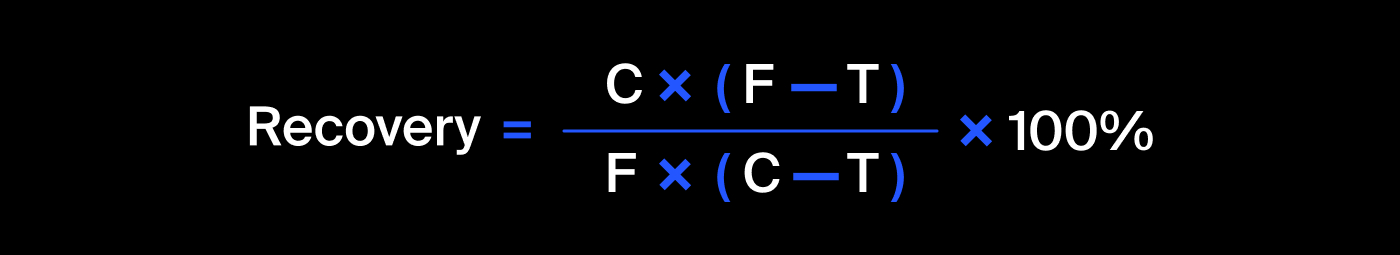
</br>
Здесь :</br>
C — доля золота в концентрате после флотации/очистки;</br>
F — доля золота в сырье/концентрате до флотации/очистки;</br>
T — доля золота в отвальных хвостах после флотации/очистки.</br>

In [15]:
def recovery(C, F, T):
    return 100 * (C * (F - T)/(F * (C - T)))

In [16]:
recovery_calc = pd.Series(
    recovery(df_full['rougher.output.concentrate_au'], df_full['rougher.input.feed_au'], df_full['rougher.output.tail_au']))

In [17]:
print(f'МАЕ между расчётным и фактическим уровнем обогащения для флотации:', mean_absolute_error(df_full['rougher.output.recovery'], recovery_calc))

МАЕ между расчётным и фактическим уровнем обогащения для флотации: 9.874045668302637e-15


Видим, что фактические данные совпадают с расчётными.

### Предобработка данных

In [18]:
#меняем формат даты для всех трёх датасетов

df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%dT%H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%dT%H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%dT%H:%M:%S')

У нас есть пропущенные строки и в тестовых данных, и в обучающих. </br>
Чем меньше мы вносим искажений в данные, тем лучше. Поэтому если пропусков мало (например, 1% от датасета или меньше), можем просто их удалить. </br>
Посмотрим, каков процент строк мы потеряем, если уберём строки с пропусками (в обучающей выборке смотрим в первую очередь данные, на которых будем обучать модель, т.е. list_of_tedt_features).

In [19]:
print('Доля строк с пропущенными значениями в тестовой выборке', (len(df_test) - len(df_test.dropna()))/len(df_test))

Доля строк с пропущенными значениями в тестовой выборке 0.011531190926275992


In [20]:
print('Доля строк с пропущенными значениями в обучающей выборке', 
      (len(df_train[list_of_test_features]) - len(df_train[list_of_test_features].dropna()))/len(df_train[list_of_test_features]))

Доля строк с пропущенными значениями в обучающей выборке 0.10389426814615874


В тестовой выборке это чуть более процента, поэтому просто удаляем. </br>
В обучающей выборке это 10%, применим KNNImputer, сразу ко всему датасету. Чтобы убедиться, что мы не внесли значимых искажений, посчитаем среднее и медиану по всем столбцам до и после заполнения пропусков и применим к ним МАЕ для сравнения.

In [21]:
df_test.dropna(inplace=True)

In [22]:
list_for_dropna = list(df_train.columns)
list_for_dropna.remove('date')

mean_before_knnimputer = df_train.mean(numeric_only=True)
median_before_knnimputer = df_train.median(numeric_only=True)

for feature in list_for_dropna:
    imputer = KNNImputer()
    df_train[feature] = imputer.fit_transform(df_train[[feature]])
    
mean_after_knnimputer = df_train.mean(numeric_only=True)
median_after_knnimputer = df_train.median(numeric_only=True)

In [23]:
print('МАЕ средних обучающего датасета до и после заполнения пропусков', mean_absolute_error(mean_before_knnimputer, mean_after_knnimputer))

МАЕ средних обучающего датасета до и после заполнения пропусков 2.747569613686294e-13


In [24]:
print('МАЕ медиан обучающего датасета до и после заполнения пропусков', mean_absolute_error(median_before_knnimputer, median_after_knnimputer)) 

МАЕ медиан обучающего датасета до и после заполнения пропусков 0.02553394173131567


**Выводы:**</br>
Для решения задачи у нас есть исторические данные о параметрах процессов золотообогащения: около 20.000 наблюдений с 87 признаками, включая целевые. Из них доступны для прогнозирования 53 признака.</br>
Данные предварительно разделены на обучающие и тестовые.</br>
Была проверена правильность расчёта эффективности обогащения, изменили формат даты и заполнили пропуски в данных.

## Исследовательский анализ данных

### Изучение признаков

Для более подробного знакомства с признаками воспользуемся модулем pandas_profiling в минимальной конфигурации.

In [ ]:
pp.ProfileReport(df_train, minimal=True)

In [ ]:
pp.ProfileReport(df_test, minimal=True)

В обучающей выборке представлены данные за 2016, 2017 и 2018 годы. В тестовой - только за 2016 и 2018 г.</br>
На гистограммах, описывающих концентрацию, видно некоторое количество нулевых значений.</br>
Гистограмы, описывающие параметры floatbank-ов имеют достаточно узкое распределение.</br>
Столбцы с калькуляцией по сути являются константой. </br>
Отдельные распределения (например, финальная концентрация коллоида) имеют бимодальную форму распределения. </br>

### Сравнение размеров гранул на обучающей и тестовой выборках

Посмотрим, как выглядят распределения гранул на обучающей и тестовой выборке (если мы обучимся на одном диапазоне, а предсказывать будем на другом - модель не заработает).

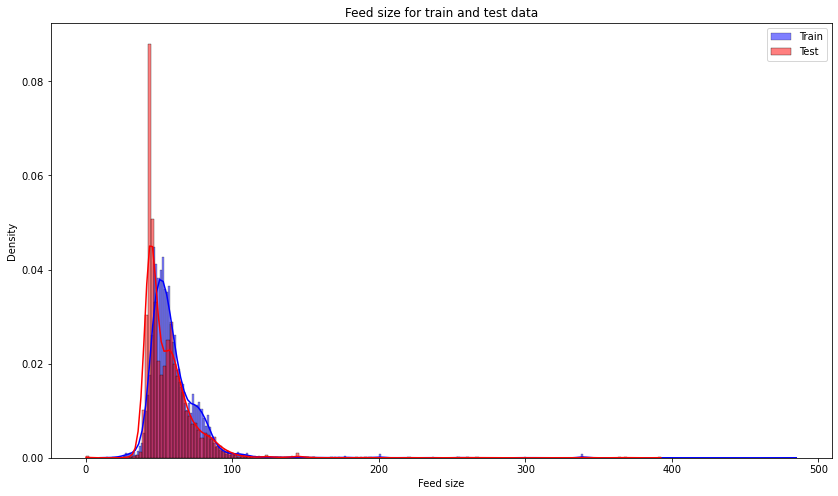

In [25]:
plt.figure(figsize=(14,8))
sns.histplot(df_train['rougher.input.feed_size'], color='blue', kde=True, stat='density', label='Train');
sns.histplot(df_test['rougher.input.feed_size'], color='red', kde=True, stat='density', label='Test');
plt.title('Feed size for train and test data', fontsize=12)
plt.xlabel('Feed size')
plt.ylabel('Density')
plt.legend()
plt.show()

Средние значения выборок достаточно сильно разнесены, да и стандартные отклонения различаются. </br>
Кроме того, распределения имеют ярко выраженные хвосты в область больших значений, а также имеют нулевые значения. Возможно, удаление экстремально больших и экстремально низких значений позволит улучшить работу модели.</br>

Выведем статистику по размерам гранул на обучающей и тестовой выборке.</br>

In [26]:
display(df_train['rougher.input.feed_size'].describe())
display(df_test['rougher.input.feed_size'].describe())

count    14149.000000
mean        60.110518
std         22.304104
min          9.659576
25%         48.994530
50%         55.511718
75%         65.918384
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher.input.feed_size, dtype: float64

Проверим утверждение о том, что в тестовой и обучающей выборке распределение размера исходных гранул различается.</br>
Пойдем от противного и выдвинем нулевую гипотезу о том, что распределение гранул в тестовой выборке равно среднему значению распределения гранул в тренировочной выборке. </br>
Альтернативная гипотеза - они различаются.</br>
Уровень значимости p-value возьмем 0,05.

In [27]:
#определим функцию проверки

def verdict(pvalue, alpha):
    print('pvalue = ', pvalue, ';', 'alpha =', alpha)
    if pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [28]:
#определим уровень значимости
alpha = 0.05

#проверим гипотезу t-критерием Стьюдента
results = st.ttest_ind(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'], equal_var=True)
verdict(results.pvalue, alpha)

pvalue =  2.6357509437728903e-34 ; alpha = 0.05
Отвергаем нулевую гипотезу


Распределения гранул train и test различаются. Однако, это различие не выглядит критичным - обучаясь на трейне, модель получит все необходимые данные из того же диапазона, в котором лежит тест.

Проделаем ту же проверку для размера гранул после флотации и на этапе первичной очистки.

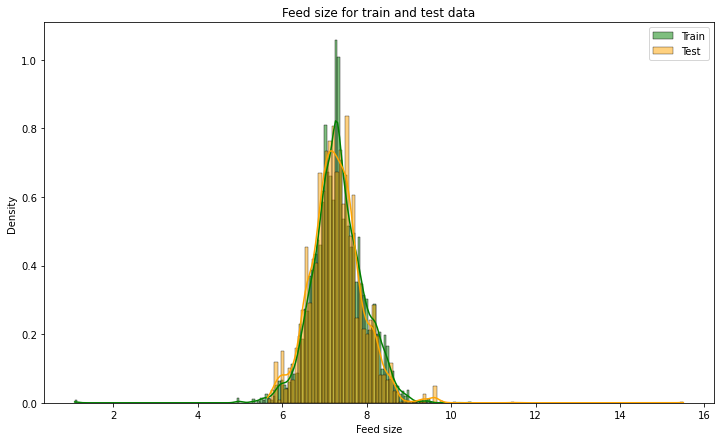

In [29]:
plt.figure(figsize=(12, 7))
sns.histplot(df_train['primary_cleaner.input.feed_size'], color='green', kde=True, stat='density', label='Train');
sns.histplot(df_test['primary_cleaner.input.feed_size'], color='orange', kde=True, stat='density', label='Test');
plt.title('Feed size for train and test data', fontsize=12)
plt.xlabel('Feed size')
plt.ylabel('Density')
plt.legend()
plt.show()

In [30]:
display(df_train['primary_cleaner.input.feed_size'].describe())
display(df_test['primary_cleaner.input.feed_size'].describe())

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

count    5229.000000
mean        7.271546
std         0.605887
min         5.650000
25%         6.900000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

In [31]:
#определим уровень значимости
alpha = 0.05

#проверим гипотезу t-критерием Стьюдента
results = st.ttest_ind(df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size'], equal_var=True)
verdict(results.pvalue, alpha)

pvalue =  2.9804815000366216e-07 ; alpha = 0.05
Отвергаем нулевую гипотезу


Кажется логичным проверить, что все признаки так или иначе не сильно отличаются диапазонами распределений.</br>
Чтобы не закапываться проверку гипотез, в качестве быстрой проверки посчитаем относительную разницу между средними.

In [32]:
(abs(abs(df_train[list_of_test_features].mean(numeric_only=True)) - abs(df_test[list_of_test_features].mean(numeric_only=True)))    /abs(df_train[list_of_test_features].mean(numeric_only=True)))    .sort_values(ascending=False)

primary_cleaner.input.xanthate                0.571010
primary_cleaner.input.sulfate                 0.318945
secondary_cleaner.state.floatbank5_b_air      0.241594
secondary_cleaner.state.floatbank5_a_air      0.234900
rougher.input.floatbank11_sulfate             0.231136
rougher.input.feed_au                         0.188481
secondary_cleaner.state.floatbank4_a_air      0.183175
rougher.input.floatbank10_sulfate             0.181464
secondary_cleaner.state.floatbank3_a_air      0.129587
secondary_cleaner.state.floatbank2_b_air      0.117701
secondary_cleaner.state.floatbank6_a_air      0.113621
secondary_cleaner.state.floatbank4_b_air      0.111773
secondary_cleaner.state.floatbank2_a_air      0.110760
rougher.input.floatbank10_xanthate            0.107850
rougher.input.floatbank11_xanthate            0.106838
rougher.input.feed_ag                         0.093521
rougher.input.feed_pb                         0.079313
rougher.state.floatbank10_a_level             0.071682
secondary_

Выделим топ-10 признаков с самым большим разбросом и построим для них гистограммы.

In [33]:
#формируем список признаков

train_test_comparison_list = (
    (abs(abs(df_train[list_of_test_features].mean(numeric_only=True)) 
    - abs(df_test[list_of_test_features].mean(numeric_only=True)))
    /abs(df_train[list_of_test_features].mean(numeric_only=True)))
    .sort_values(ascending=False).index
    )

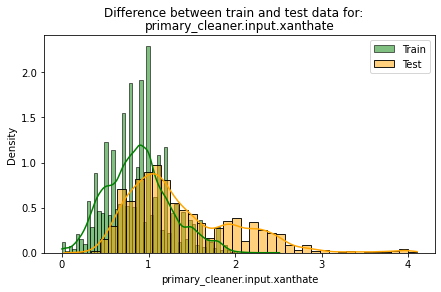

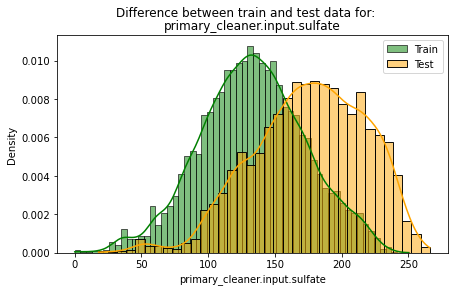

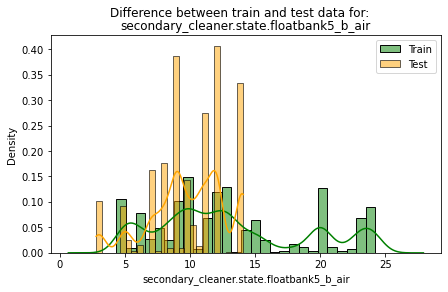

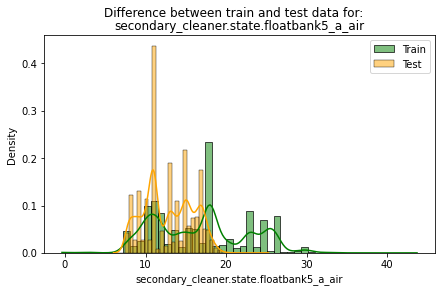

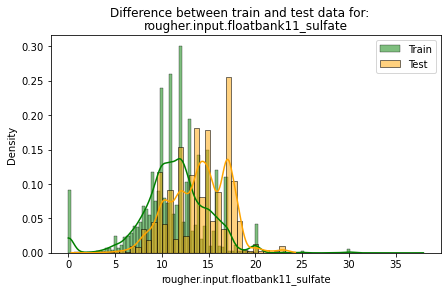

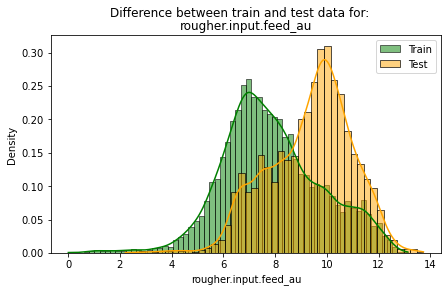

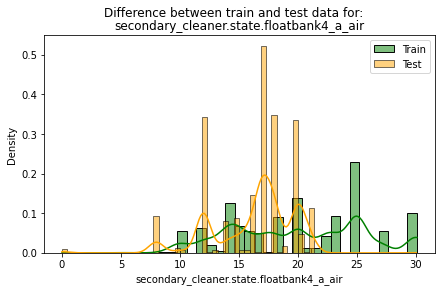

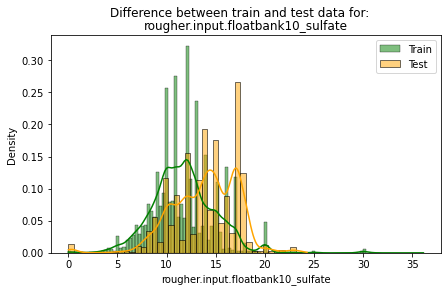

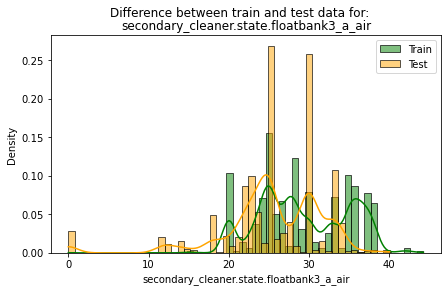

In [34]:
#в цикле строим гистограммы
for col_name in train_test_comparison_list[:9]:
    plt.figure(figsize=(7, 4))
    sns.histplot(df_train[col_name], color='green', kde=True, stat='density', label='Train');
    sns.histplot(df_test[col_name], color='orange', kde=True, stat='density', label='Test');
    plt.title(col_name)
    plt.suptitle('Difference between train and test data for:', fontsize=12)
    plt.xlabel(col_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Видим, что некоторые признаки сильно различаются на тестовой и тренировочной выборках. Но несмотря на различие средних, их диапазоны почти полностью перекрываются, а значит модель обучится и на тех значениях, которые есть и в тестовой, и в обучающей выборках.</br> 
Но теоретически здесь может быть поле для улучшения модели, если сделать распределения данных более соответствующими друг другу.

### Изучение концентрации металлов на разных этапах очистки

Изучим концентрацию металлов на начальном этапе и после всех этапов очистки.

In [35]:
#создаем датасет с концентрациями

df_concentrate = pd.concat([
    df_full[[feature for feature in list_of_features if 'concentrate' in feature and 'au' in feature and 'output' in feature]]
    .sort_index(ascending=False, axis=1),
    df_full[[feature for feature in list_of_features if 'concentrate' in feature and 'ag' in feature]]
    .sort_index(ascending=False, axis=1),
    df_full[[feature for feature in list_of_features if 'concentrate' in feature and 'pb' in feature]]
    .sort_index(ascending=False, axis=1),
    df_full[[feature for feature in list_of_features if 'concentrate' in feature and 'sol' in feature]]
    .sort_index(ascending=False, axis=1)
])

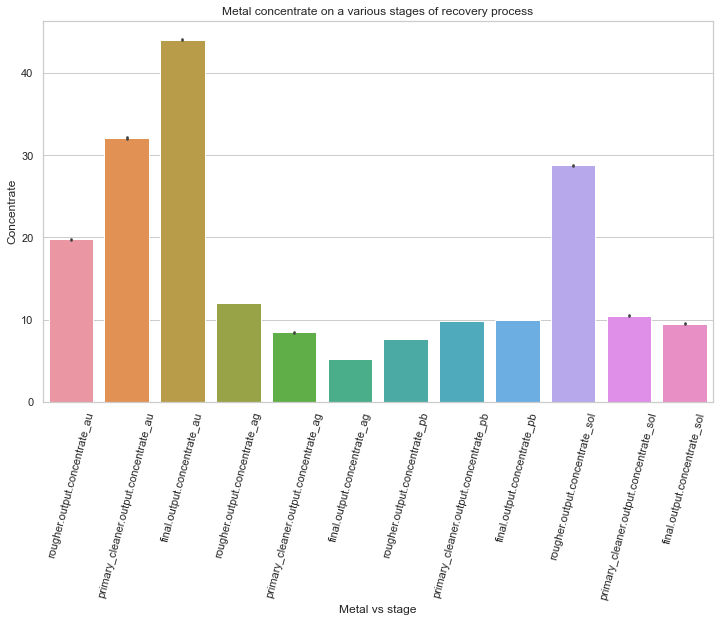

In [36]:
plt.figure(figsize=(12,7))
sns.set(style="whitegrid")
sns.barplot(data=df_concentrate);
plt.title('Metal concentrate on a various stages of recovery process', fontsize=12)
plt.xlabel('Metal vs stage')
plt.ylabel('Concentrate')
plt.xticks(rotation = 75)
plt.show()

Содержание золота растёт от этапа к этапу, обогащение работает.

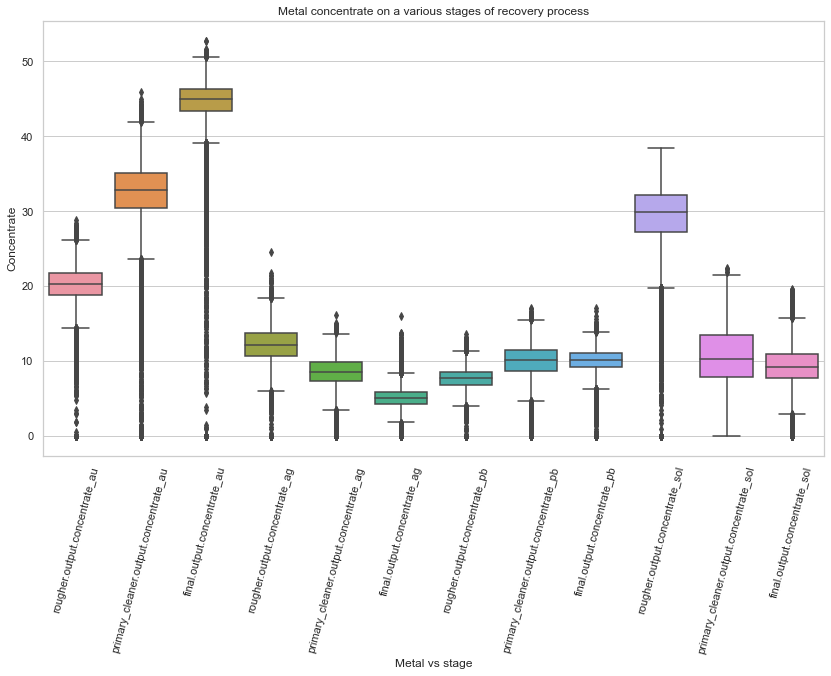

In [37]:
# построим ящики с усами для этих признаков

plt.figure(figsize=(14,8))
sns.set(style="whitegrid")
plt.title('Metal concentrate on a various stages of recovery process', fontsize=12)
plt.xlabel('Metal vs stage')
plt.ylabel('Concentrate')
sns.boxplot(data=df_concentrate);
plt.xticks(rotation = 75)
plt.show()

Видим большое количество выбросов фактически у всех металлов. Особенно подозрительно смотрятся нулевые значения концентрации золота в золотообогатительном процессе.</br>
С одной стороны, для эффективного обучения модели нужно очистить данные от выбросов.</br>
С другой - вероятно, заказчик хотел бы получить максимально приближенную к реальным условиям модель, которая не сломается в случае выбросов в процессе работы.</br>
Оптимальным решением, вероятно, будет очистка самых "грубых" выбросов, составляющих небольшой процент от всех возможных ситуаций (например, 1%).

Построим распределения металлов для каждого этапа очистки отдельно.

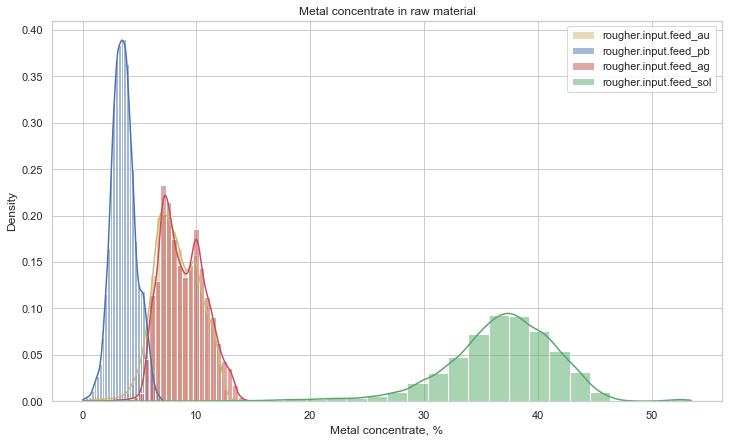

In [38]:
plt.figure(figsize=(12,7))
sns.histplot(df_full['rougher.input.feed_au'], bins=30, color='y', kde=True, stat='density', label='rougher.input.feed_au');
sns.histplot(df_full['rougher.input.feed_pb'], bins=30, color='b', kde=True, stat='density', label='rougher.input.feed_pb');
sns.histplot(df_full['rougher.input.feed_ag'], bins=30, color='r', kde=True, stat='density', label='rougher.input.feed_ag');
sns.histplot(df_full['rougher.input.feed_sol'], bins=30, color='g', kde=True, stat='density', label='rougher.input.feed_sol');
plt.legend()
plt.title('Metal concentrate in raw material')
plt.xlabel('Metal concentrate, %')
plt.ylabel('Density')
plt.show()

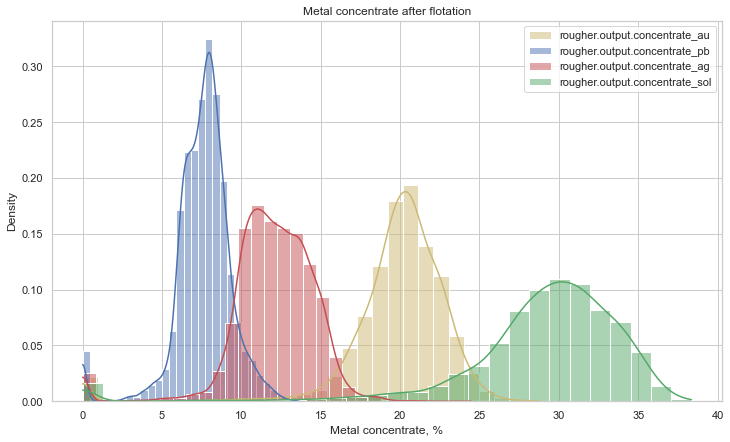

In [39]:
plt.figure(figsize=(12,7))
sns.histplot(df_concentrate['rougher.output.concentrate_au'], bins=30, color='y', kde=True, stat='density', label='rougher.output.concentrate_au');
sns.histplot(df_concentrate['rougher.output.concentrate_pb'], bins=30, color='b', kde=True, stat='density', label='rougher.output.concentrate_pb');
sns.histplot(df_concentrate['rougher.output.concentrate_ag'], bins=30, color='r', kde=True, stat='density', label='rougher.output.concentrate_ag');
sns.histplot(df_concentrate['rougher.output.concentrate_sol'], bins=30, color='g', kde=True, stat='density', label='rougher.output.concentrate_sol');
plt.legend()
plt.title('Metal concentrate after flotation')
plt.xlabel('Metal concentrate, %')
plt.ylabel('Density')
plt.show()

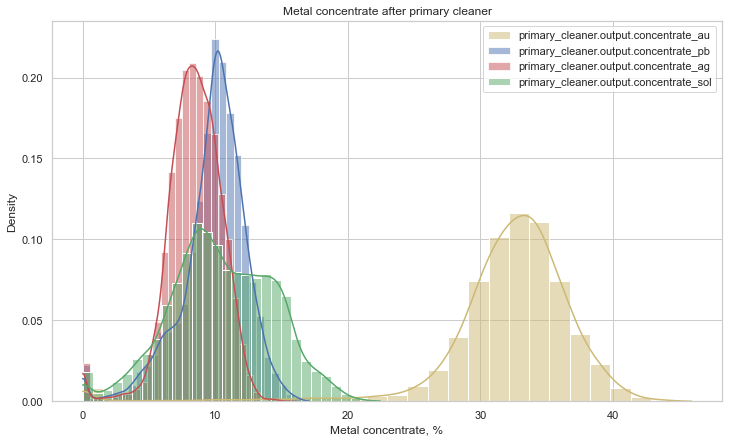

In [40]:
plt.figure(figsize=(12,7))
sns.histplot(df_concentrate['primary_cleaner.output.concentrate_au'], bins=30, color='y', kde=True, stat='density', label='primary_cleaner.output.concentrate_au');
sns.histplot(df_concentrate['primary_cleaner.output.concentrate_pb'], bins=30, color='b', kde=True, stat='density', label='primary_cleaner.output.concentrate_pb');
sns.histplot(df_concentrate['primary_cleaner.output.concentrate_ag'], bins=30, color='r', kde=True, stat='density', label='primary_cleaner.output.concentrate_ag');
sns.histplot(df_concentrate['primary_cleaner.output.concentrate_sol'], bins=30, color='g', kde=True, stat='density', label='primary_cleaner.output.concentrate_sol');
plt.legend()
plt.title('Metal concentrate after primary cleaner')
plt.xlabel('Metal concentrate, %')
plt.ylabel('Density')
plt.show()

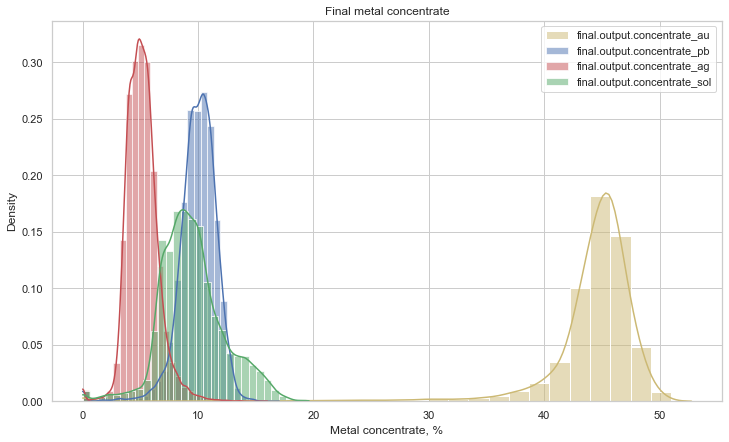

In [41]:
plt.figure(figsize=(12,7))
sns.histplot(df_concentrate['final.output.concentrate_au'], bins=30, color='y', kde=True, stat='density', label='final.output.concentrate_au');
sns.histplot(df_concentrate['final.output.concentrate_pb'], bins=30, color='b', kde=True, stat='density', label='final.output.concentrate_pb');
sns.histplot(df_concentrate['final.output.concentrate_ag'], bins=30, color='r', kde=True, stat='density', label='final.output.concentrate_ag');
sns.histplot(df_concentrate['final.output.concentrate_sol'], bins=30, color='g', kde=True, stat='density', label='final.output.concentrate_sol');
plt.legend()
plt.title('Final metal concentrate')
plt.xlabel('Metal concentrate, %')
plt.ylabel('Density')
plt.show()

Видно, как к финальному этапу очистки концентрация золота "уползает" от остальных металлов, а распределения становятся более узкими - вероятно за счёт ухода "хвостов". </br>
На всех стадиях видны нулевые (или близкие к нулевым) значения концентраций.</br>
Чтобы проверить, связаны ли эти нули между собой, построим суммарные графики концентрации всех металлов для разных этапов.

In [42]:
input_concentrate = (df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_pb'] 
    + df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_sol'])
rougher_concentrate = (df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_pb']
    + df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_sol'])
primary_concentrate = (df_full['primary_cleaner.output.concentrate_au'] + df_full['primary_cleaner.output.concentrate_pb']
    + df_full['primary_cleaner.output.concentrate_ag'] + df_full['primary_cleaner.output.concentrate_sol'])
final_concentrate = (df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_pb']
    + df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_sol'])

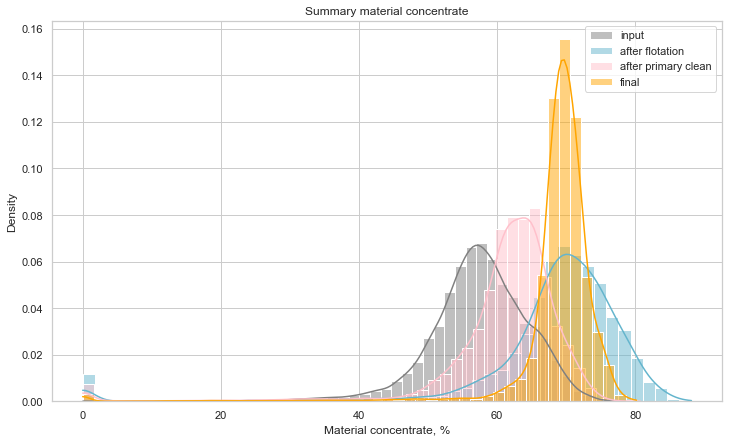

In [43]:
plt.figure(figsize=(12,7))
sns.histplot(input_concentrate, bins=50, color='grey', kde=True, stat='density', label='input');
sns.histplot(rougher_concentrate, bins=50, color='c', kde=True, stat='density', label='after flotation');
sns.histplot(primary_concentrate, bins=50, color='pink', kde=True, stat='density', label='after primary clean');
sns.histplot(final_concentrate, bins=50, color='orange', kde=True, stat='density', label='final');
plt.legend()
plt.title('Summary material concentrate')
plt.xlabel('Material concentrate, %')
plt.ylabel('Density')
plt.show()

Видно, что в данных присутствет достаточно большое количество наблюдений, в которых суммарная концентрация металлов, включая золото, равна нулю. Вероятно, это ошибочные записи или ситуации, когда установка запускалась "вхолостую" для обслуживания итд. </br> 
В обучении эти наблюдения для нас бесполезны (как и "нулевой" хвост), поэтому удалим из тренировочного датасета строки, в которых суммарная концентрация металлов ниже 20%.

In [44]:
df_train['input_concentrate'] = (df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_pb'] 
    + df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_sol'])
df_train['rougher_concentrate'] = (df_train['rougher.output.concentrate_au'] + df_train['rougher.output.concentrate_pb']
    + df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_sol'])
df_train['primary_concentrate'] = (df_train['primary_cleaner.output.concentrate_au'] + df_train['primary_cleaner.output.concentrate_pb']
    + df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_sol'])
df_train['final_concentrate'] = (df_train['final.output.concentrate_au'] + df_train['final.output.concentrate_pb']
    + df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_sol'])

In [45]:
#длина датасета до удаления
len_before = len(df_train)

In [46]:
df_train = df_train[df_train['input_concentrate'] > 20]
df_train = df_train[df_train['rougher_concentrate'] > 20]
df_train = df_train[df_train['primary_concentrate'] > 20]
df_train = df_train[df_train['final_concentrate'] > 20]

In [47]:
print('Доля удаленных строк:', (len_before - len(df_train))/len_before)

Доля удаленных строк: 0.046151671496218814


Еще раз посмотрим на распределение и на то, как изменились выбросы.

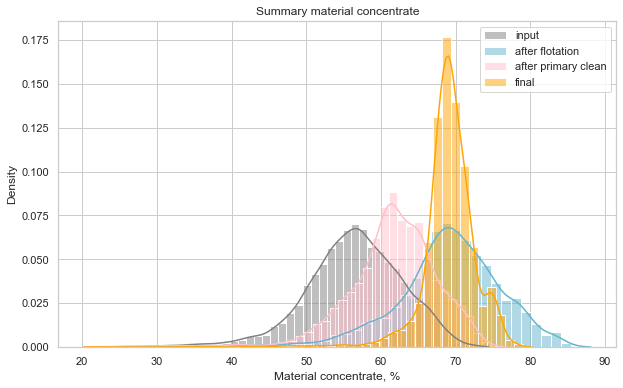

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['input_concentrate'], bins=50, color='grey', kde=True, stat='density', label='input');
sns.histplot(df_train['rougher_concentrate'], bins=50, color='c', kde=True, stat='density', label='after flotation');
sns.histplot(df_train['primary_concentrate'], bins=50, color='pink', kde=True, stat='density', label='after primary clean');
sns.histplot(df_train['final_concentrate'], bins=50, color='orange', kde=True, stat='density', label='final');
plt.legend()
plt.title('Summary material concentrate')
plt.xlabel('Material concentrate, %')
plt.ylabel('Density')
plt.show()

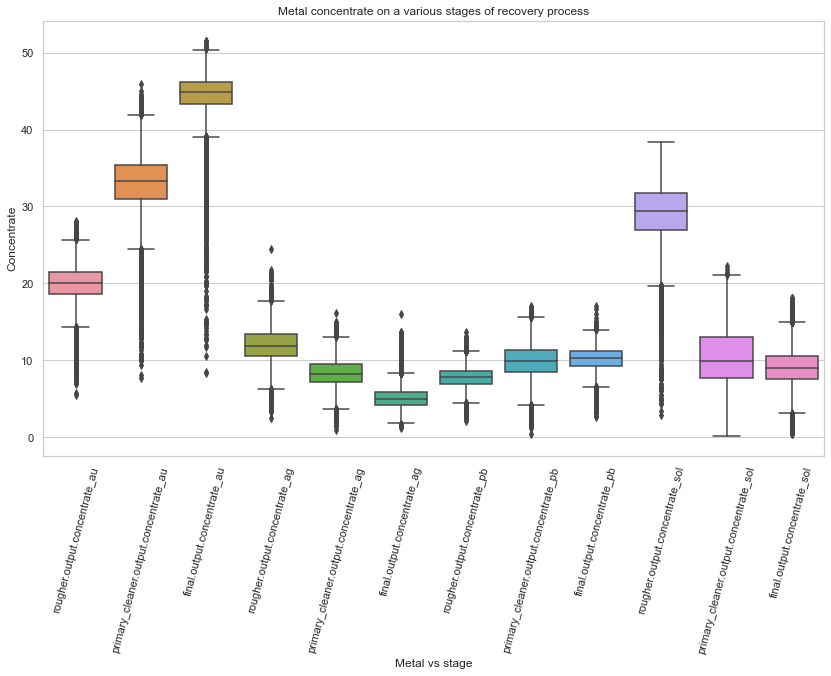

In [49]:
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
sns.boxplot(data=df_train[df_concentrate.columns]);
plt.title('Metal concentrate on a various stages of recovery process', fontsize=12)
plt.xlabel('Metal vs stage')
plt.ylabel('Concentrate')
plt.xticks(rotation = 75)
plt.show()

Видим, что после удаления нулевых значений, выбросов стало меньше.</br>
Уберем 1% самых экстремальных значений сверху и снизу, проверим, насколько уменьшился датасет.

In [50]:
len_before = len(df_train)
for column in df_concentrate.columns:
    #print(column)
    low = df_train[column].quantile(0.005)
    upper = df_train[column].quantile(0.995)
    df_train = df_train[(df_train[column] > low) & (df_train[column] < upper)]
    #print(len(df_train))

In [51]:
print('Доля удаленных строк:', (len_before - len(df_train))/len_before)

Доля удаленных строк: 0.11440426793123888


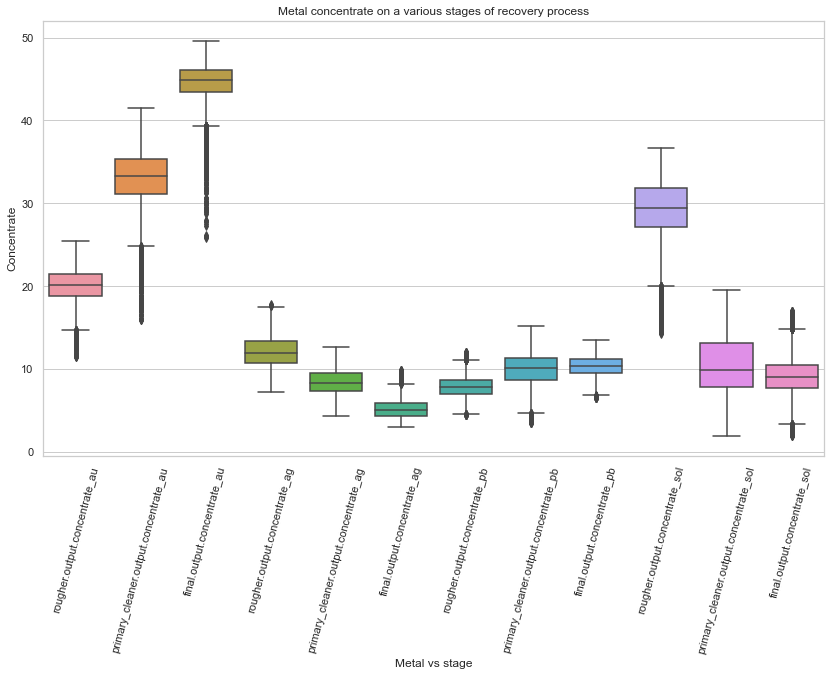

In [52]:
#смотрим выбросы еще раз

plt.figure(figsize=(14,8))
sns.set(style="whitegrid")
sns.boxplot(data=df_train[df_concentrate.columns]);
plt.title('Metal concentrate on a various stages of recovery process', fontsize=12)
plt.xlabel('Metal vs stage')
plt.ylabel('Concentrate')
plt.xticks(rotation = 75)
plt.show()

Выбросов стало намного меньше, однако здесь еще есть поле для улучшения с удалением оставшихся выбросов.

### Изучение корреляции признаков

Для начала построим хитмап обучающей выборки (только признаки, которые есть в тестовой).

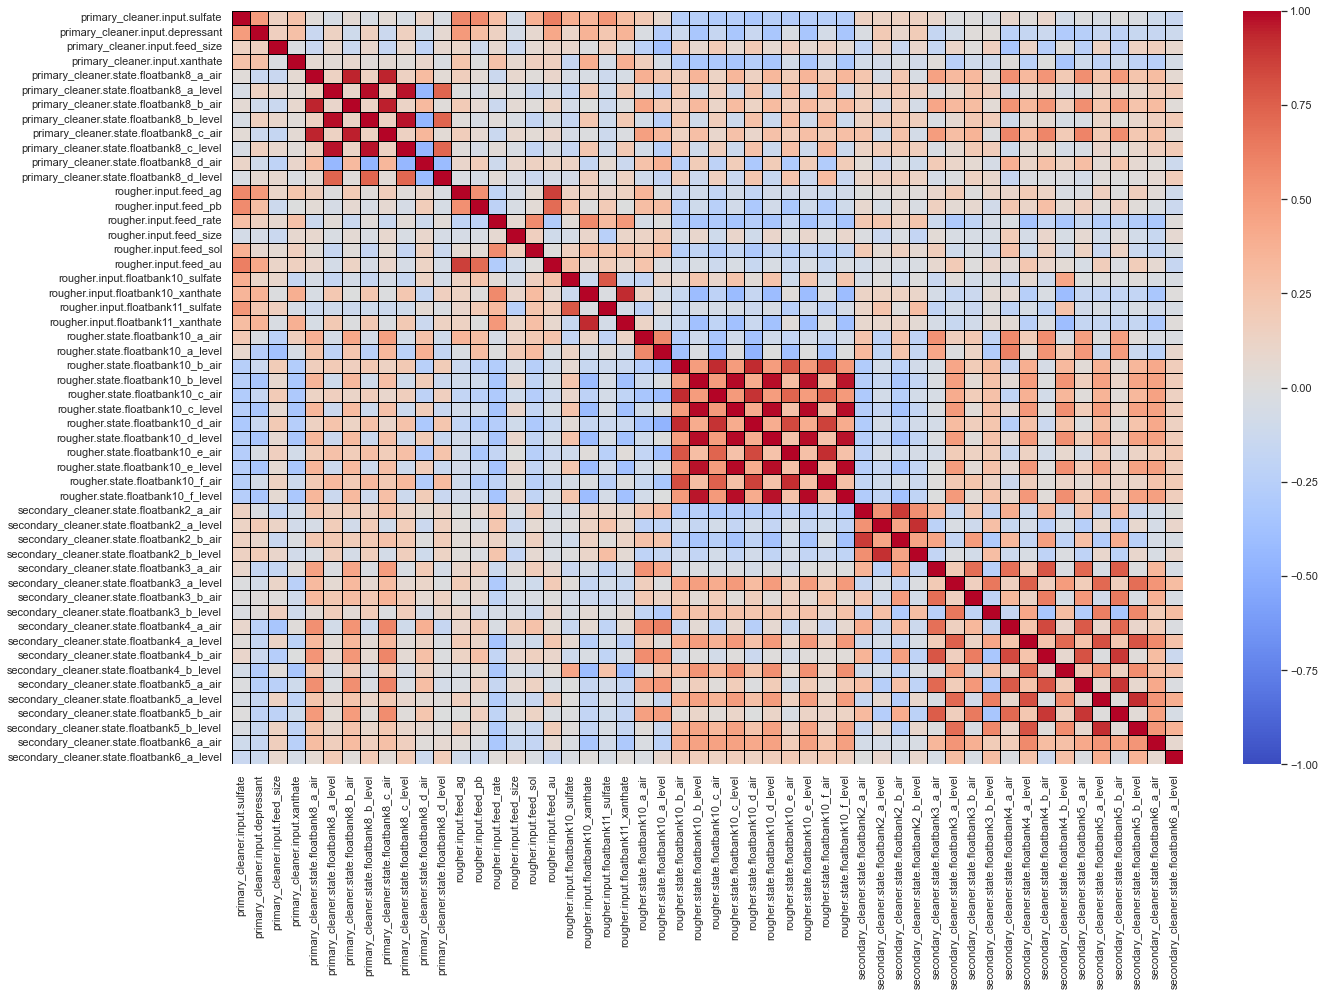

In [53]:
fig = plt.figure(figsize=(20, 14))
sns.heatmap(df_train[list_of_test_features].corr(), annot = False, vmin = -1, vmax = 1, center = 0, linewidths = 1, linecolor = 'black', cmap= 'coolwarm')
fig.tight_layout()
plt.show()

Масштаб получился слишком маленький для изучения, но даже в таком формате видны несколько блоков признаков, коррелирующих друг с другом.</br>
Разобьем хитмап на этапы очистки - флотация, первичная очистка, вторичная очистка.

In [54]:
#делаем списки фич

flotation_test_features = [feature for feature in list_of_test_features if 'rougher' in feature]
primary_test_features = [feature for feature in list_of_test_features if 'primary' in feature]
secondary_test_features = [feature for feature in list_of_test_features if 'secondary' in feature]
print(len(flotation_test_features) + len(primary_test_features) + len(secondary_test_features))

52


### Изучаем флотацию

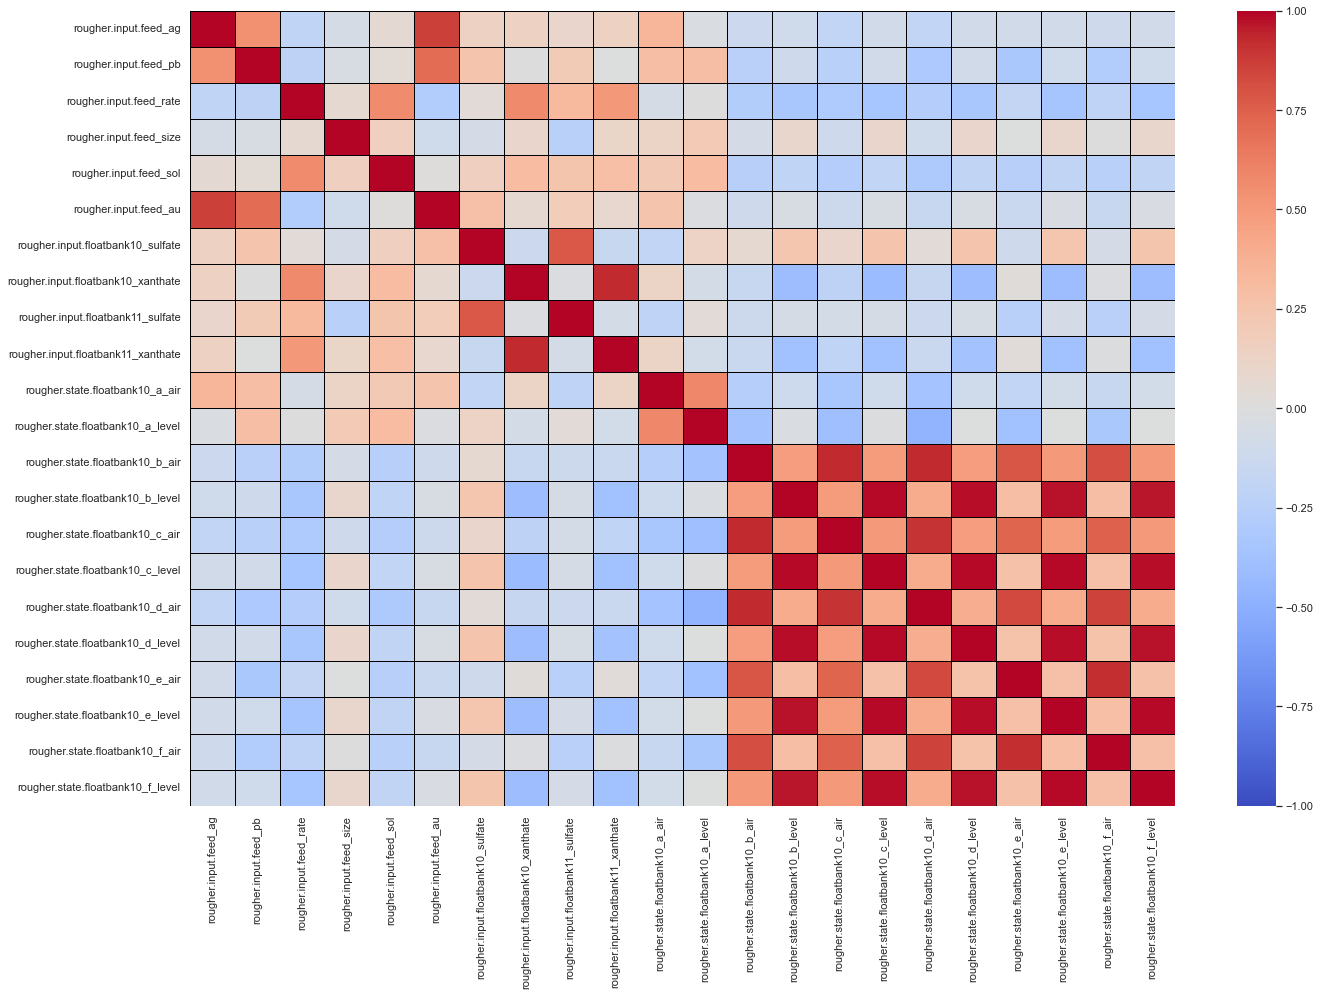

In [55]:
fig = plt.figure(figsize=(20, 14))
sns.heatmap(df_train[flotation_test_features].corr(), annot = False, vmin = -1, vmax = 1, center = 0, linewidths = 1, linecolor = 'black', cmap= 'coolwarm')
fig.tight_layout()
plt.show()

Есть целый блок флотационных установок с высокой попарной корреляцией параметров! </br>
Вероятно, эти установки работают параллельно и для них задают одинаковые параметры, разделяя сырье между ними.</br>
Исходя из этого предположения можно попробовать сократить количество признаков, усреднив параметры этих установок в один новый признак. Или применив метод главных компонент PCA.

In [56]:
df_train[flotation_test_features].describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,...,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000
mean,8.630720,3.545015,475.898319,60.114504,36.543107,7.963592,11.806256,5.902772,11.434349,5.936302,...,1326.672426,-462.118220,1306.307500,-463.001833,1215.919082,-463.464995,1095.988345,-462.824917,1040.544012,-462.632758
std,1.848524,1.020841,99.683804,22.380850,4.531333,1.849910,3.019503,1.055066,3.506206,1.061152,...,179.510313,57.766546,211.585109,56.168498,207.471247,55.985622,180.559087,56.828068,174.986051,56.847236
min,2.926127,0.088552,0.022802,9.659576,5.495734,1.513062,0.001164,0.001428,0.001557,0.000290,...,-0.653384,-558.967560,-0.035112,-610.357519,-0.124766,-640.519003,-1.936877,-648.002444,-2.430587,-649.880981
25%,7.175376,2.820840,427.914943,49.200083,34.220770,6.669853,9.995601,5.198998,9.738726,5.204217,...,1199.657364,-500.163271,1105.282424,-500.188777,1085.852503,-500.311166,998.923753,-500.219943,902.528488,-500.420406
50%,8.214378,3.438078,499.479070,55.543062,37.087896,7.741564,11.844548,5.995475,11.499847,5.997283,...,1302.209488,-499.733107,1300.836559,-499.635184,1201.263667,-499.397644,1051.969987,-499.565829,1000.126918,-499.282450
75%,9.945027,4.217170,545.015155,65.698908,39.471181,9.155841,13.717317,6.697436,13.502311,6.699809,...,1450.011256,-400.312578,1450.651622,-400.491886,1347.650213,-400.818457,1200.076157,-400.463479,1100.296220,-400.750685
max,14.596026,7.142594,717.508837,484.967466,48.195295,13.076836,30.631803,9.703448,30.011666,9.698407,...,1809.194008,-298.036622,2499.129174,-292.155509,1817.199290,-282.986203,1922.636637,-272.199598,1706.307502,-191.718480


Смотрим статистики. Средние и дисперсии очень близки. То, что они не одинаковы, можно объяснить следующим образом: параметры работы вводятся в соответствии с технологическим процессом, но поскольку оборудование имеет метрологические допуски, изнашивается итд - реальные цифры дают некоторый разброс.</br>
</br>
Выведем гистограммы и графики, чтобы убедиться, что профили данных похожи для разных флотационных установок.

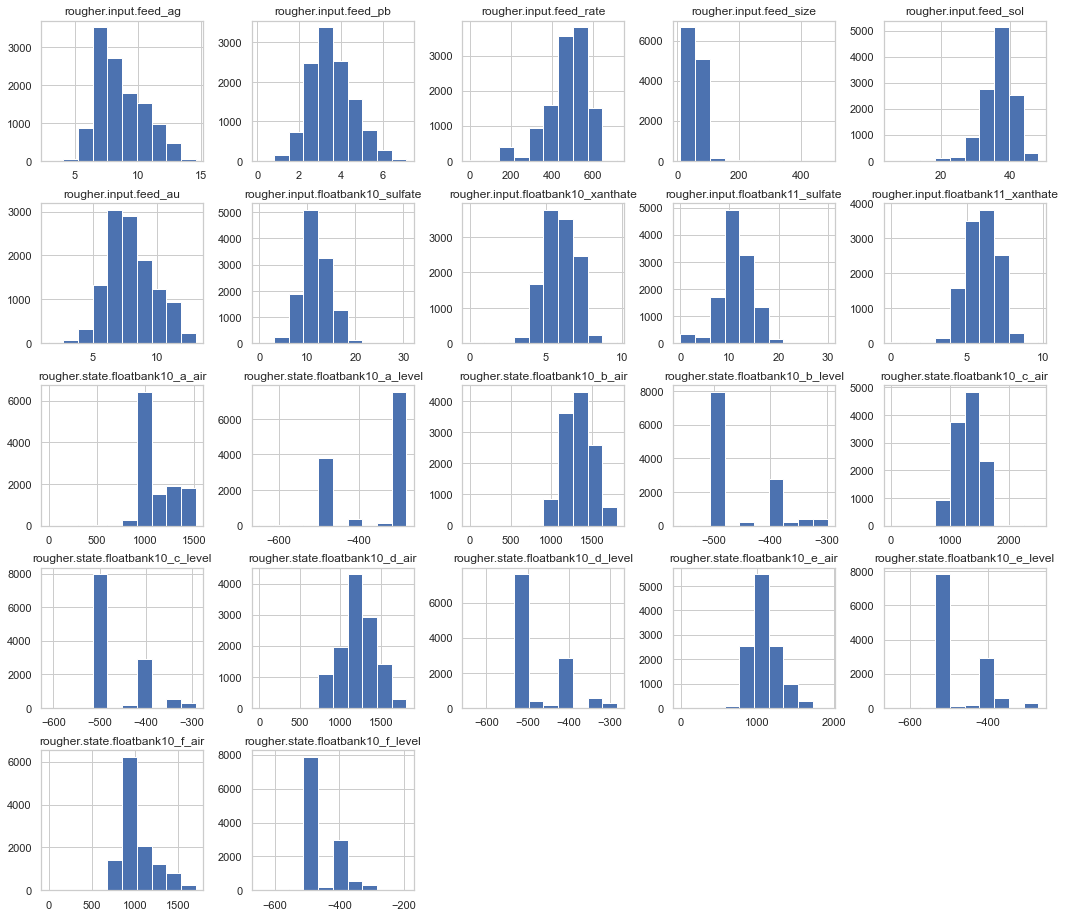

In [57]:
df_train[flotation_test_features].hist(figsize=(18, 16));

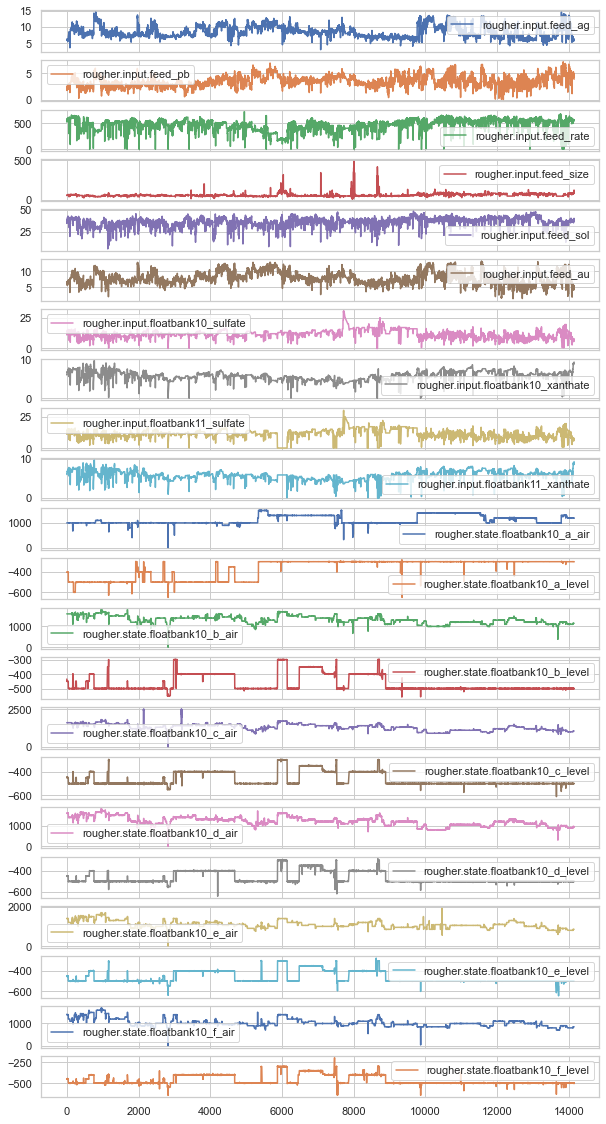

In [58]:
df_train[flotation_test_features].plot(subplots=True, figsize=(10,20));

**Смотрим те же параметры для этапа первичной очистки.**

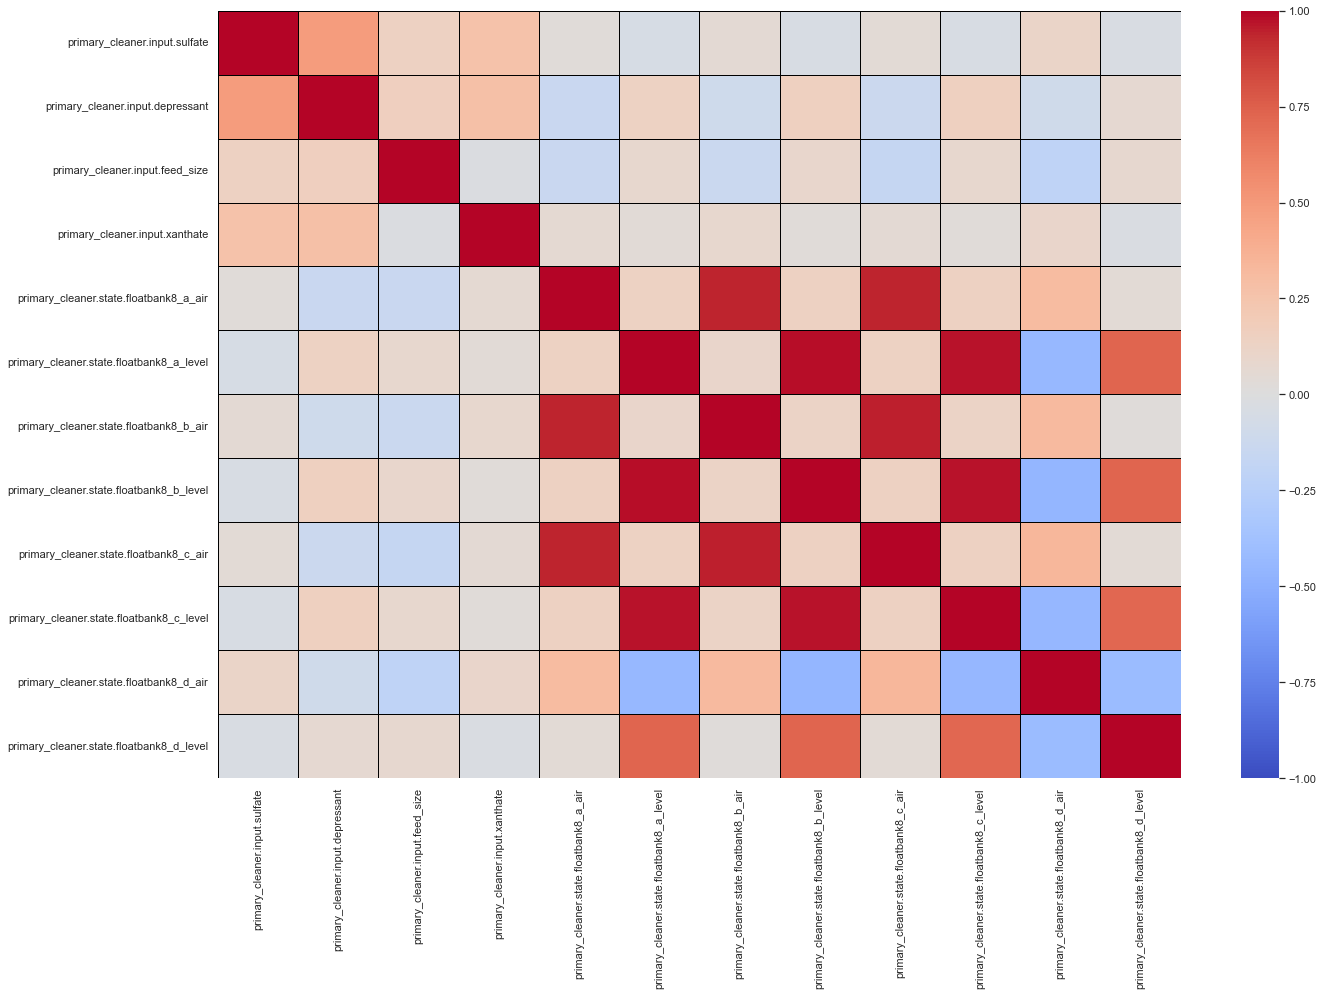

In [59]:
fig = plt.figure(figsize=(20, 14))
sns.heatmap(df_train[primary_test_features].corr(), annot = False, vmin = -1, vmax = 1, center = 0, linewidths = 1, linecolor = 'black', cmap= 'coolwarm')
fig.tight_layout()
plt.show()

In [60]:
df_train[primary_test_features].describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level
count,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000
mean,135.983011,8.937394,7.333940,0.886404,1612.795878,-488.302599,1613.427560,-488.825994,1613.833939,-488.875811,1545.106037,-483.197588
std,37.430995,3.305129,0.594474,0.371070,123.039107,34.607152,125.970736,33.266170,127.467560,33.889870,277.659353,45.645700
min,0.832935,0.000000,1.080000,0.000154,304.788187,-633.597180,306.005110,-613.701205,292.647271,-714.602533,131.321672,-799.761641
25%,110.629745,6.072625,6.970000,0.609470,1596.901617,-500.272469,1595.596644,-500.357316,1562.325927,-500.569744,1460.452402,-500.438564
50%,135.117514,8.042621,7.300000,0.885588,1602.041336,-499.904064,1602.060603,-499.926913,1601.782918,-499.856265,1600.283261,-499.823772
75%,160.784109,11.498720,7.700000,1.098175,1699.895514,-499.368654,1700.432210,-499.386067,1700.606252,-498.780857,1699.465420,-498.421258
max,250.070701,20.036965,10.470000,2.512968,2079.531340,-347.074526,1823.922970,-347.354380,1867.634284,-346.653450,2398.888373,-30.601828


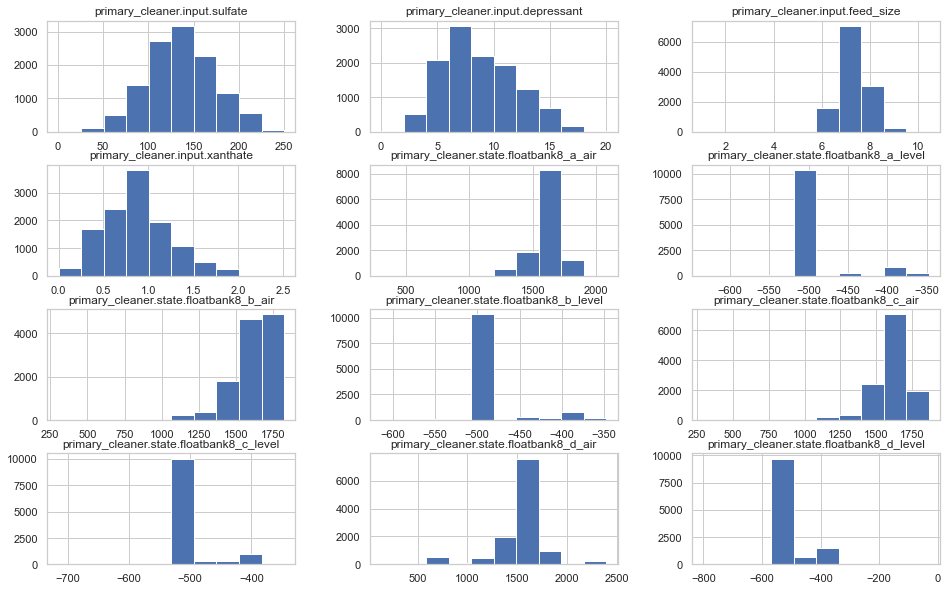

In [61]:
df_train[primary_test_features].hist(figsize=(16,10));

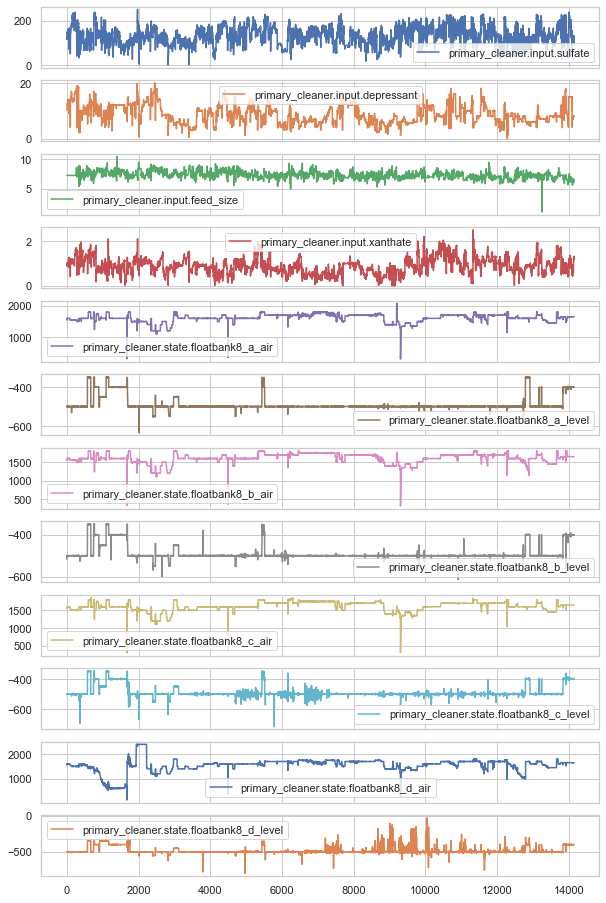

In [62]:
df_train[primary_test_features].plot(subplots=True, figsize=(10,16));

Видим, что и тут есть целый блок из установок, параметры которых очень сильно коррелируют между собой. </br>
Стоит обратить внимание, что Floatbank 8d коррелирует намного слабее, да и гистограмма у него отличается. Это либо блок другого этапа, либо более изношенное оборудование - в любом случае, его показания отличаются и в обшую переменную его включать, видимо, не стоит.

**Смотрим те же параметры для этапа вторичной очистки.**

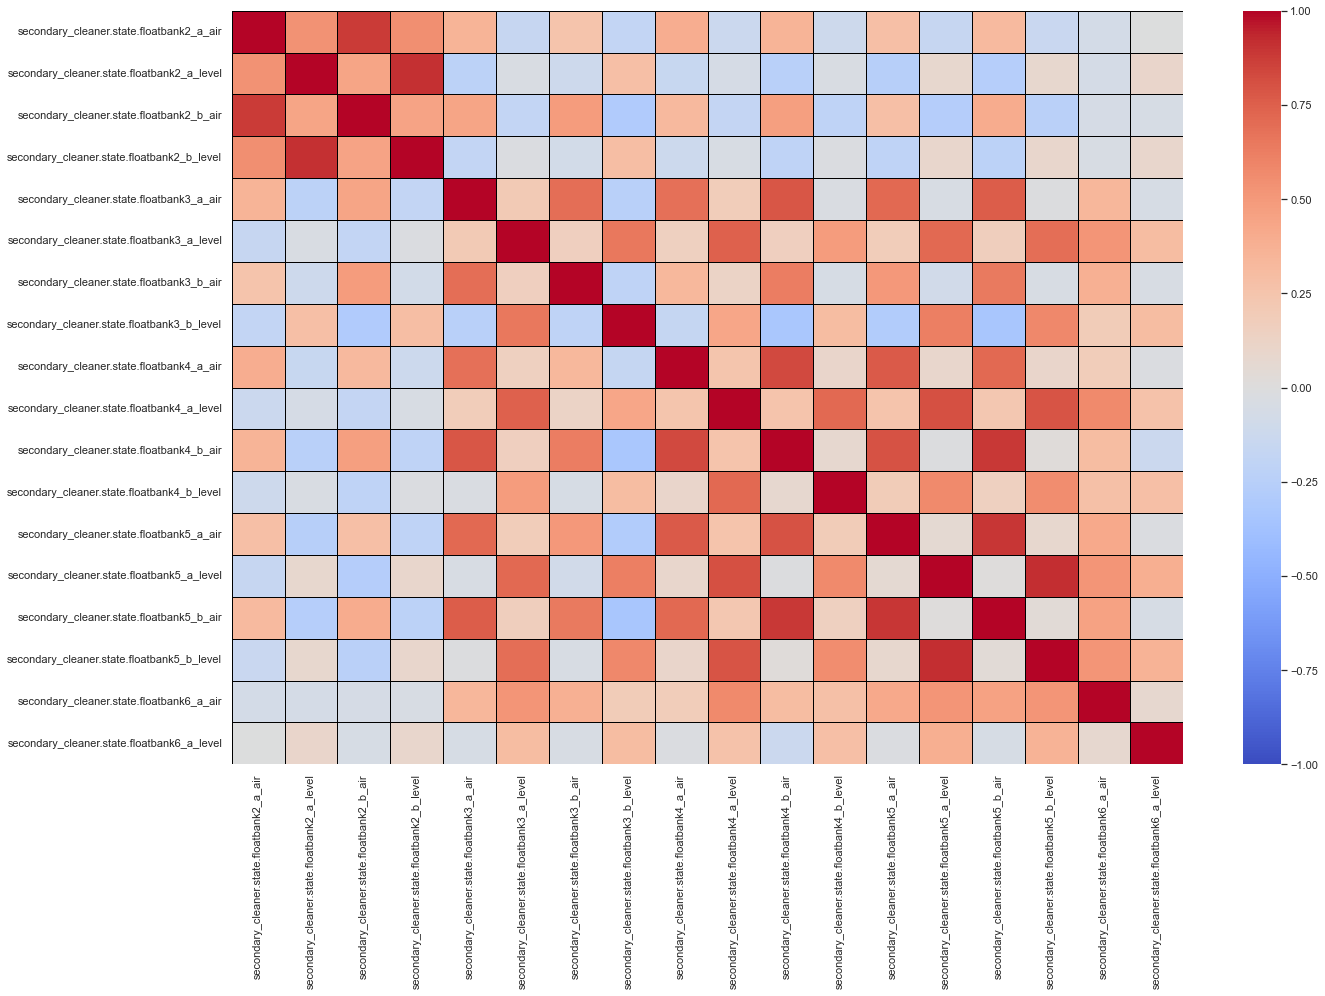

In [63]:
fig = plt.figure(figsize=(20, 14))
sns.heatmap(df_train[secondary_test_features].corr(), annot = False, vmin = -1, vmax = 1, center = 0, linewidths = 1, linecolor = 'black', cmap= 'coolwarm')
fig.tight_layout()
plt.show()

In [64]:
df_train[secondary_test_features].describe()

,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000
mean,29.646852,-502.575760,24.916196,-503.803320,29.315591,-476.258077,22.658621,-488.101266,20.087599,-476.799391,15.556914,-459.048930,16.890036,-482.656443,13.132367,-482.751459,19.747948,-505.902043
std,5.823193,61.758826,6.045939,64.551475,5.629871,54.306268,5.035592,41.037765,5.561517,51.092504,5.255074,57.837514,5.843287,38.377194,5.803103,38.505637,5.750263,35.191556
min,0.122013,-799.606441,0.000000,-799.873878,9.958318,-799.560407,6.771627,-757.517138,5.006961,-799.706757,4.815717,-799.860840,-0.372054,-637.398127,1.358469,-799.989583,0.246972,-809.392602
25%,25.104444,-500.249736,22.061480,-500.269015,24.995470,-500.166558,19.913346,-500.107287,15.011184,-500.579418,11.923464,-500.130756,11.134236,-500.330113,8.998047,-500.100149,14.990924,-500.702418
50%,30.025230,-499.961770,27.027996,-500.010947,28.017099,-499.867627,22.035929,-499.963728,20.008088,-499.635131,14.978109,-499.343428,17.959543,-499.665097,12.006578,-499.907025,19.991855,-500.057594
75%,34.898737,-499.601371,28.970627,-499.759275,34.992659,-400.692434,25.973744,-499.750400,24.990633,-402.475821,20.076771,-400.020677,21.993000,-451.153187,18.010134,-450.218076,24.993093,-499.537573
max,52.651399,-166.933103,35.152122,-212.064665,44.260464,-191.678810,35.072841,-163.888539,30.084500,-245.239184,24.007913,-145.071088,43.709931,-275.073125,24.803684,-183.442252,32.188906,-104.427459


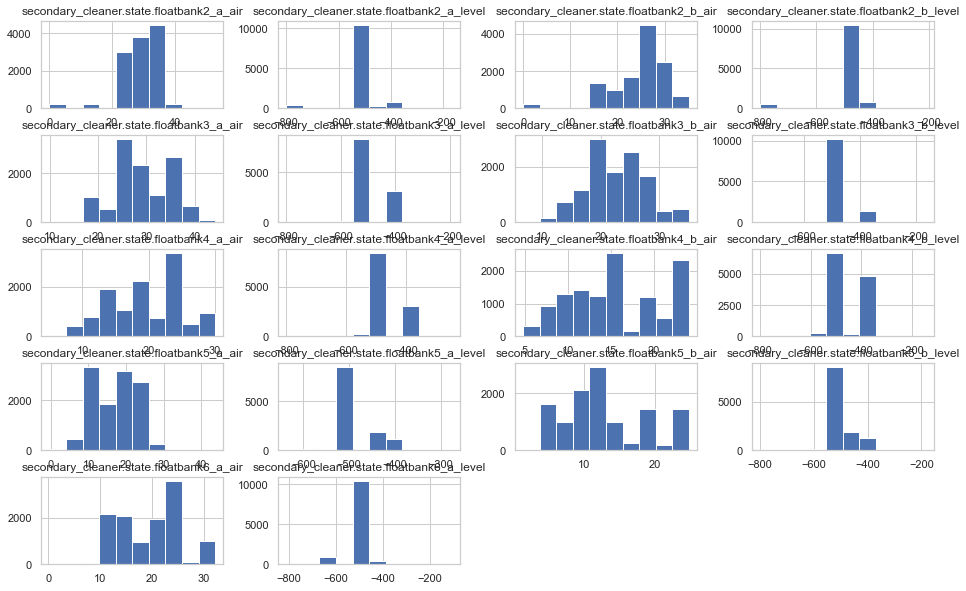

In [65]:
df_train[secondary_test_features].hist(figsize=(16,10));

По сути, весь вторичный этап в наших данных состоит только из параметров флотационных установок - но ведут они себя по-разному, поэтому при уменьшении размерности это тоже нужно учитывать.

### Целевые признаки

Еще раз посмотрим, как выглядят гистограммы искомых параметров в обучающей выборке, очищенной от нулей и выбросов.

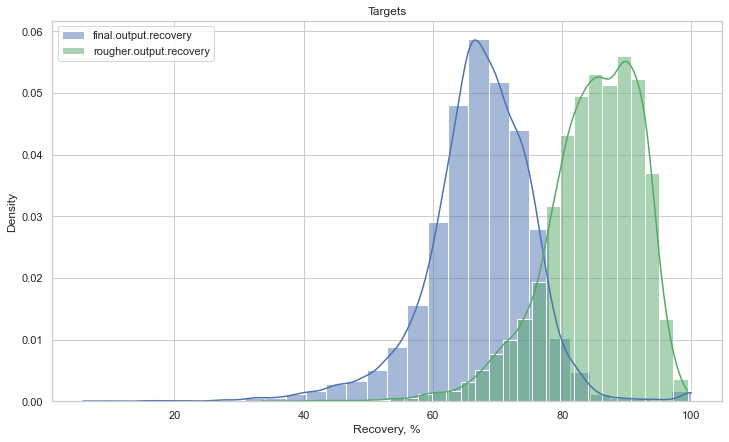

In [66]:
plt.figure(figsize=(12,7))
sns.histplot(df_train['final.output.recovery'], bins=30, color='b', kde=True, stat='density', label='final.output.recovery');
sns.histplot(df_train['rougher.output.recovery'], bins=30, color='g', kde=True, stat='density', label='rougher.output.recovery');
plt.legend()
plt.title('Targets')
plt.xlabel('Recovery, %')
plt.ylabel('Density')
plt.show()

### Выводы

Проведен исследовательский анализ данных:
- изучены основные характеристики и гистограмы признаков
- изучена концентрация металлов и суммарная концентрация веществ на разных этапах очистки
- изучены распределения признаков в обучающей и тестовой выборке, проведено сравнение
- изучена корреляции параметров
- из обучающей выборки удалены нули и выбросы
- обозначены варианты для дальнейшего улучшения датасета (в частности - для уменьшения размерности)

### Метрика качества sMAPE

Введём метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение») по следующей формуле:
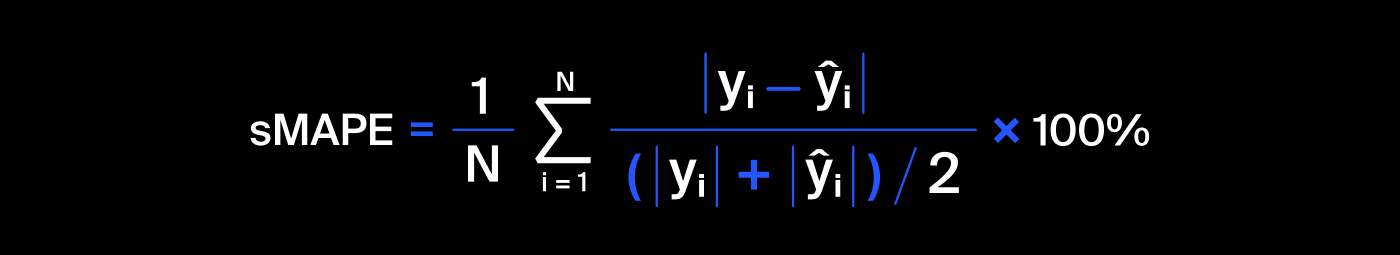

In [67]:
def sMAPE(target, predict):
    target = target.to_numpy()
    target_rougher = target[:, 0]
    target_final = target[:, 1]
    predict_rougher = predict[:, 0]
    predict_final = predict[:, 1]
    
    rougher_error = abs(target_rougher - predict_rougher)
    rougher_score = (abs(target_rougher) + abs(predict_rougher))/2
    smape_rougher = 100 * (rougher_error/ rougher_score).mean()
    
    final_error = abs(target_final - predict_final)
    final_score = (abs(target_final) + abs(predict_final))/2
    smape_final = 100 * (final_error/final_score).mean()  

    smape = .25 * smape_rougher + 0.75 * smape_final
    return smape    

In [68]:
#делаем скорер

smape_scorer = make_scorer(sMAPE, greater_is_better=True)

В созданном скорере оставляем метрику greater_is_better=True, чтобы избежать отрицательных чисел на кросс-валидации из-за особенностей работы скорера в режиме greater_is_better=False. </br>
Для текущей задачи метрику необходимо минимизировать (по модулю).

## Отбор признаков, подготовка обучающей и тестовой выборки

In [69]:
features = pd.DataFrame(df_train, columns=list_of_test_features)
features.drop(columns='date', axis=1, inplace=True)
target = df_train[['rougher.output.recovery', 'final.output.recovery']]

In [70]:
target_test = df_full[df_full['date'].isin(df_test['date'])]
target_test = target_test[['rougher.output.recovery', 'final.output.recovery']]

In [71]:
df_test.drop(columns='date', axis=1, inplace=True)

Признаки имеют разный масштаб, поэтому масштабируем выборку, применив StandartScaler

In [72]:
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)
df_test_scaled =  scaler.transform(df_test)

### Снижение размерности

Сформируем отдельную выборку с пониженной размерностью. Отберем параметры floatbank-ов, имеющих высокую взаимную корреляцию и усредним значения их параметров (air и level - естественно, по отдельности).</br>
Потом проделаем то же самое с помощью метода главных компонент.</br>

In [73]:
#создаем лист признаков без сильно коррелирующих величин

list_of_crop_features = (['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
                          'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level',
                           'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size',
                           'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 
                          'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
                           'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank3_a_air',
                           'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level',
                           'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air',
                           'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level',
                           'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air',
                           'secondary_cleaner.state.floatbank6_a_level'])

In [74]:
#создаем датафрейм с признаками

features_crop = pd.DataFrame(df_train, columns=list_of_crop_features)

In [75]:
#создаем новые столбцы на базе коррелирующих обычным усреднением

features_crop['rougher.joinedfloatbank.air'] = (df_train['rougher.state.floatbank10_b_air'] + df_train['rougher.state.floatbank10_c_air']
                        + df_train['rougher.state.floatbank10_d_air'] + df_train['rougher.state.floatbank10_e_air'] 
                        + df_train[ 'rougher.state.floatbank10_f_air'])/5

features_crop['rougher.joinedfloatbank.level'] = (df_train['rougher.state.floatbank10_b_level'] + df_train['rougher.state.floatbank10_c_level']
                        + df_train['rougher.state.floatbank10_d_level'] + df_train['rougher.state.floatbank10_e_level'] 
                        + df_train[ 'rougher.state.floatbank10_f_level'])/5

In [76]:
features_crop['primary_cleaner.joinedfloatbank.air'] = (df_train['primary_cleaner.state.floatbank8_a_air']
                        + df_train['primary_cleaner.state.floatbank8_b_air'] 
                        + df_train['primary_cleaner.state.floatbank8_c_air'])/3

features_crop['primary_cleaner.joinedfloatbank.level'] = (df_train['primary_cleaner.state.floatbank8_a_level']
                        + df_train['primary_cleaner.state.floatbank8_b_level'] 
                        + df_train['primary_cleaner.state.floatbank8_c_level'])/3

In [77]:
features_crop['secondary_cleaner.joinedfloatbank.air'] = (df_train['secondary_cleaner.state.floatbank2_a_air']
                        + df_train[ 'secondary_cleaner.state.floatbank2_b_air'])/2

features_crop['secondary_cleaner.joinedfloatbank.level'] = (df_train['secondary_cleaner.state.floatbank2_a_level']
                        + df_train[ 'secondary_cleaner.state.floatbank2_b_level'])/2

Посмотрим, как это выглядит и проверим новое число призраков

In [78]:
print(features_crop.shape)
features_crop.head()

(11952, 38)


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,...,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.joinedfloatbank.air,rougher.joinedfloatbank.level,primary_cleaner.joinedfloatbank.air,primary_cleaner.joinedfloatbank.level,secondary_cleaner.joinedfloatbank.air,secondary_cleaner.joinedfloatbank.level
0,127.092003,10.128295,7.25,0.988759,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,...,8.079666,-500.470978,14.151341,-605.841980,1525.030127,-447.123248,1550.361287,-504.660726,24.873384,-499.966385
1,125.629232,10.296251,7.25,1.002663,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,...,7.984757,-500.582168,13.998353,-599.787184,1520.141671,-450.145316,1576.037162,-500.028654,24.885034,-500.181042
2,123.819808,11.316280,7.25,0.991265,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,...,8.013877,-500.517572,14.028663,-601.427363,1519.671416,-450.076388,1601.315463,-500.491874,24.945951,-499.940772
3,122.270188,11.322140,7.25,0.996739,1600.449520,-500.052575,6.043309,2.037807,542.590390,57.792734,...,7.977324,-500.255908,14.005551,-599.996129,1519.795072,-450.096310,1600.310700,-500.452290,24.949012,-499.512773
4,117.988169,11.913613,7.25,1.009869,1602.649541,-500.593010,6.060915,1.786875,540.531893,56.047189,...,7.894242,-500.356035,13.996647,-601.496691,1520.609347,-449.765618,1600.786485,-500.062285,24.990066,-500.436353


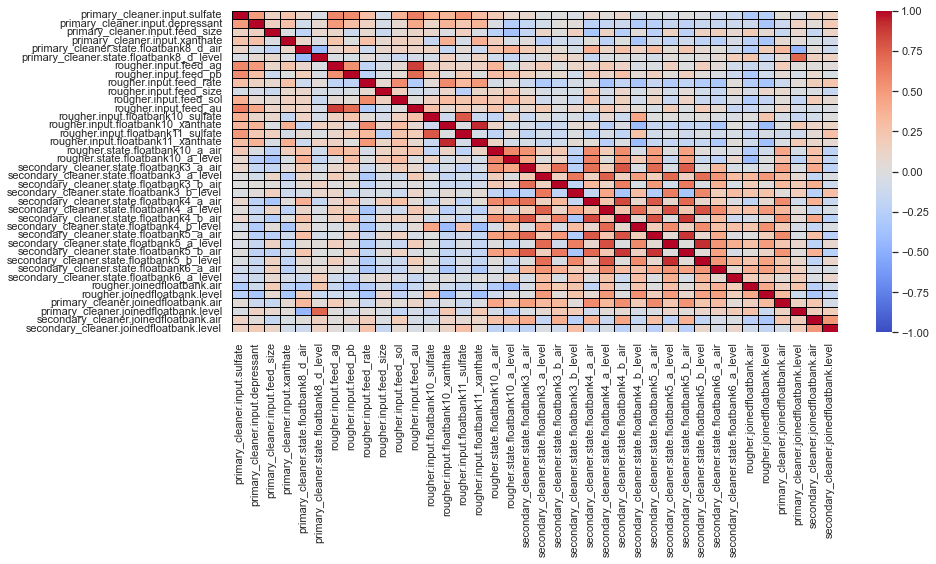

In [79]:
#посмотрим на обновленный хитмап

fig = plt.figure(figsize=(14, 8))
sns.heatmap(features_crop.corr(), annot = False, vmin = -1, vmax = 1, center = 0, linewidths = 1, linecolor = 'black', cmap= 'coolwarm')
fig.tight_layout()
plt.show()

Признаков с корреляцией близкой к единице почти не осталось.

In [80]:
#масштабируем

scaler_crop = StandardScaler()
scaler_crop.fit(features_crop)
features_crop = scaler_crop.transform(features_crop)

### Метод главных компонент для снижения размерности

Попробуем сократить признаки, используя метод из библиотеки предобработки - метод главных компонент. Применим его ко всем колонкам состояния флотационных установок, чтобы сформировать два признака, характеризующих их некую суперпозицию на каждом этапе.

In [81]:
#список признаков без установок

list_of_crop_features_pca = (['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
                          'primary_cleaner.input.xanthate', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size',
                           'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 
                          'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate'])


In [82]:
#отбираем признаки

features_crop_pca = pd.DataFrame(df_train, columns=list_of_crop_features_pca).reset_index(drop=True)

In [83]:
#формируем три новых датафрейма с floatbank.state, чтобы применить к ним PCA

rougher_floatbanks = (df_train[[feature for feature in list_of_test_features if 'floatbank' in feature and 'state' in feature 
                    and 'rougher' in feature]].sort_index(ascending=False, axis=1))
rougher_floatbanks.head()

,rougher.state.floatbank10_f_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_a_air
0,-451.939636,1416.354980,-455.462982,1404.472046,-451.294128,1598.937256,-442.204468,1602.375000,-434.715027,1603.011353,-404.066986,999.706909
1,-450.119001,1399.719514,-450.869848,1399.227084,-449.953649,1600.527589,-449.830646,1600.479580,-449.953435,1600.754587,-400.065196,1000.286398
2,-450.527147,1400.316682,-449.937588,1399.180945,-449.954185,1599.849325,-449.954491,1599.672797,-450.008530,1599.337330,-400.074028,999.719565
3,-449.790835,1400.234743,-450.030142,1400.943157,-450.130127,1597.725177,-449.910497,1600.012842,-450.619948,1600.059442,-400.200179,999.814770
4,-450.407128,1401.160227,-448.877187,1401.560902,-449.909799,1599.759049,-450.034364,1600.357732,-449.599614,1600.208824,-399.752729,999.678690


In [84]:
primary_cleaner_floatbanks = (df_train[[feature for feature in list_of_test_features if 'floatbank' in feature and 'primary' in feature 
                    and 'state' in feature]].sort_index(ascending=False, axis=1))

In [85]:
secondary_cleaner_floatbanks = (df_train[[feature for feature in list_of_test_features if 'floatbank' in feature and 'secondary' in feature 
                    and 'state' in feature]].sort_index(ascending=False, axis=1))

In [86]:
#применяем PCA

pca = PCA(n_components = 2)
XPCAreduced_rougher = pd.DataFrame(pca.fit_transform(rougher_floatbanks), columns=['rougher_pca_1', 'rougher_pca_1'])
XPCAreduced_primmary = pd.DataFrame(pca.fit_transform(primary_cleaner_floatbanks), columns=['primary_cleaner_pca_1', 'primary_cleaner_pca_1'])
XPCAreduced_secondary = pd.DataFrame(pca.fit_transform(secondary_cleaner_floatbanks), columns=['secondary_cleaner_pca_1', 'secondary_cleaner_pca_1'])

In [87]:
#объединяем с матрицей признаков

features_crop_pca = pd.concat([features_crop_pca, XPCAreduced_rougher, XPCAreduced_primmary, XPCAreduced_secondary], axis=1)

In [88]:
#проверяем, что получилось

print(features_crop_pca.shape)
features_crop_pca.head()

(11952, 20)


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher_pca_1,rougher_pca_1,primary_cleaner_pca_1,primary_cleaner_pca_1,secondary_cleaner_pca_1,secondary_cleaner_pca_1
0,127.092003,10.128295,7.25,0.988759,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,-738.162094,-20.028480,34.736078,106.703910,-70.419544,-13.543990
1,125.629232,10.296251,7.25,1.002663,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,-727.229995,-16.243688,-1.778733,74.017886,-72.396061,-13.906080
2,123.819808,11.316280,7.25,0.991265,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,-726.229372,-15.854618,-42.857837,44.786888,-70.907110,-13.672389
3,122.270188,11.322140,7.25,0.996739,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,-726.295905,-16.369849,-42.957705,46.724490,-69.725951,-14.088538
4,117.988169,11.913613,7.25,1.009869,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,-728.197432,-16.674162,-45.249615,46.826175,-70.562544,-12.725341


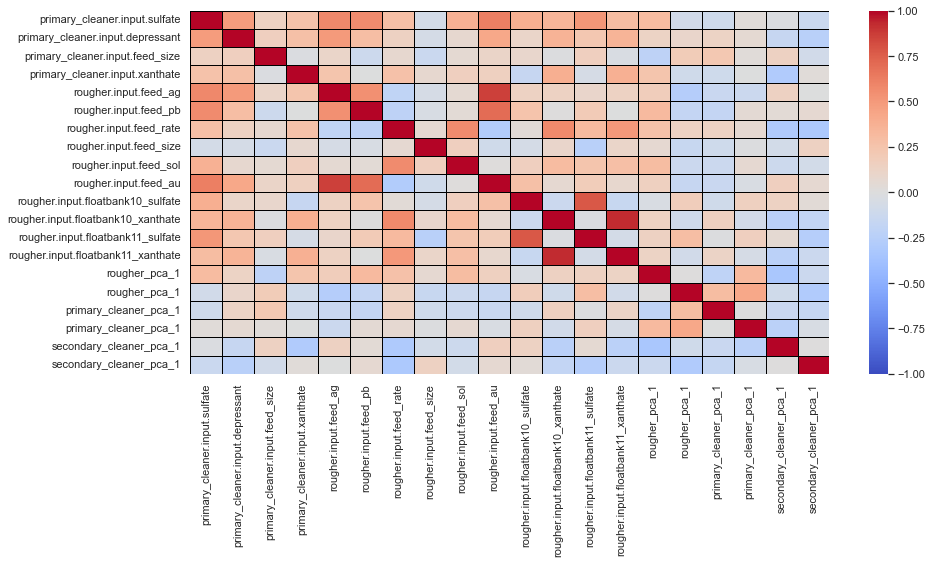

In [89]:
#посмотрим на хитмап

fig = plt.figure(figsize=(14, 8))
sns.heatmap(features_crop_pca.corr(), annot = False, vmin = -1, vmax = 1, center = 0, linewidths = 1, linecolor = 'black', cmap= 'coolwarm')
fig.tight_layout()
plt.show()

In [90]:
#добавляем масштабирование

scaler_pca = StandardScaler()
scaler_pca.fit(features_crop_pca)
features_crop_pca = scaler_pca.transform(features_crop_pca)

### Выводы

Из тренировочной выборки мы отобрали признаки в соответствии с тестовой выборкой и провели масштабирование признаков.</br>
Также мы сформировали два набора признаков со сниженной размерностью.

## Обучение моделей

Рассмотрим несколько моделей, подберем для них параметры, обучим и оценим smape с помощью кросс-валидации.
Каждую модель будем сначала обучать на немасштабированных признаках с гиперпараметрами по умолчанию - чтобы определить базовую метрику модели и в сравнении с ней оценивать "реакцию" на применяемые приемы.

### Линейная регрессия

In [91]:
lr = LinearRegression()
result = cross_val_score(lr, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для линейной регрессии на исходных признаках:', result.mean())

sMAPE для линейной регрессии на исходных признаках: 9.73321881737834


In [92]:
#создадим датафрейм, куда будем вносить метрику для каждой модели

score_table = pd.DataFrame([['LinearRegression', result.mean()]], columns=['model', 'smape score'])
score_table

,model,smape score
0,LinearRegression,9.733219


In [93]:
#линейная регрессия на стандартизированных данных

lr = LinearRegression()
result = cross_val_score(lr, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для линейной регрессии на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'LinearRegression_scaled', 'smape score': result.mean()}, ignore_index=True);

sMAPE для линейной регрессии на масштабированных признаках: 9.733218817378372


In [94]:
lr = LinearRegression()
result = cross_val_score(lr, features_crop, target, cv=5, scoring=smape_scorer)
print('sMAPE для линейной регрессии, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'LinearRegression_croped', 'smape score': result.mean()}, ignore_index=True);

sMAPE для линейной регрессии, снижение размерности усреднением коррелирующих признаков: 9.206772740950527


In [95]:
lr = LinearRegression()
result = cross_val_score(lr, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для линейной регрессии, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'LinearRegression_croped_pca', 'smape score': result.mean()}, ignore_index=True);

sMAPE для линейной регрессии, снижение размерности методом PCA: 8.119255015999618


Масштабирование улучшения для линейной регрессии не дает, зато положительно сказывается сокращение размерности.

### LASSO регрессия

In [96]:
lasso = Lasso(random_state=RANDOM_STATE)
lasso.fit(features, target)
result = cross_val_score(lasso, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso регрессии на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'Lasso', 'smape score': result.mean()}, ignore_index=True);

sMAPE для Lasso регрессии на исходных признаках: 9.04680648154975


In [97]:
lasso = Lasso(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
lasso2 = GridSearchCV(lasso, grid_params)
lasso2.fit(features_scaled, target)

print(lasso2.best_estimator_)

result = cross_val_score(lasso2.best_estimator_, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso регрессии на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'Lasso_scaled', 'smape score': result.mean()}, ignore_index=True);

Lasso(alpha=0.5, random_state=25)
sMAPE для Lasso регрессии на масштабированных признаках: 7.893342372385769


In [98]:
lasso = Lasso(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
lasso2 = GridSearchCV(lasso, grid_params)
lasso2.fit(features_crop, target)

print(lasso2.best_estimator_)

result = cross_val_score(lasso2.best_estimator_, features_crop, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso-регрессии, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'Lasso_crop', 'smape score': result.mean()}, ignore_index=True);

Lasso(alpha=0.5, random_state=25)
sMAPE для Lasso-регрессии, снижение размерности усреднением коррелирующих признаков: 7.898827660351486


In [99]:
lasso = Lasso(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
lasso2 = GridSearchCV(lasso, grid_params)
lasso2.fit(features_crop_pca, target)

print(lasso2.best_estimator_)

result = cross_val_score(lasso2.best_estimator_, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso-регрессии, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'Lasso_crop_pca', 'smape score': result.mean()}, ignore_index=True);

Lasso(alpha=0.1, random_state=25)
sMAPE для Lasso-регрессии, снижение размерности методом PCA: 7.907480765687073


Лассо-регрессия хорошо подходит для ситуаций с большим количеством признаков с высокой мультиколлинеарностью. Видимо, поэтому сокращение размерности не дало никакого улучшения - зато стандартизация дала существенное снижение метрики.

In [100]:
smape_scorer1 = make_scorer(sMAPE, greater_is_better=False)

In [105]:
lasso = Lasso(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
lasso2 = GridSearchCV(lasso, grid_params, scoring=smape_scorer1, cv=5)
lasso2.fit(features_crop_pca, target)

print(lasso2.best_estimator_)

result = cross_val_score(lasso2.best_estimator_, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso-регрессии, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'Lasso_crop_pca', 'smape score': result.mean()}, ignore_index=True);

Lasso(alpha=0.1, random_state=25)
sMAPE для Lasso-регрессии, снижение размерности методом PCA: 7.907480765687073


### Ридж регрессия

In [99]:
ridge = Ridge(random_state=RANDOM_STATE)
ridge.fit(features, target)
result = cross_val_score(ridge, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso регрессии на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'Ridge', 'smape score': result.mean()}, ignore_index=True);

sMAPE для Lasso регрессии на исходных признаках: 9.73254563538747


In [100]:
ridge = Ridge(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
ridge2 = GridSearchCV(ridge, grid_params)
ridge2.fit(features_scaled, target)

print(ridge2.best_estimator_)

result = cross_val_score(ridge2.best_estimator_, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso регрессии на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'Ridge_scaled', 'smape score': result.mean()}, ignore_index=True);

Ridge(random_state=25)
sMAPE для Lasso регрессии на масштабированных признаках: 9.723431756920068


In [103]:
ridge = Ridge(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
ridge2 = GridSearchCV(ridge, grid_params, scoring=smape_scorer1, cv=5)
ridge2.fit(features_scaled, target)

print(ridge2.best_estimator_)

result = cross_val_score(ridge2.best_estimator_, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso регрессии на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'Ridge_scaled', 'smape score': result.mean()}, ignore_index=True);

Ridge(random_state=25)
sMAPE для Lasso регрессии на масштабированных признаках: 9.723431756920068


In [101]:
ridge = Ridge(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
ridge2 = GridSearchCV(ridge, grid_params)
ridge2.fit(features_crop, target)

print(ridge2.best_estimator_)

result = cross_val_score(ridge2.best_estimator_, features_crop, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso-регрессии, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'Ridge_croped', 'smape score': result.mean()}, ignore_index=True);

Ridge(random_state=25)
sMAPE для Lasso-регрессии, снижение размерности усреднением коррелирующих признаков: 9.202851764650086


In [102]:
ridge = Ridge(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
ridge2 = GridSearchCV(ridge, grid_params)
ridge2.fit(features_crop_pca, target)

print(ridge2.best_estimator_)

result = cross_val_score(ridge2.best_estimator_, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для Lasso-регрессии, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'Ridge_croped_pca', 'smape score': result.mean()}, ignore_index=True);

Ridge(random_state=25)
sMAPE для Lasso-регрессии, снижение размерности методом PCA: 8.11817473707896


Гребневая регрессия отличается способом регуляризации, но по результатам метрики ведёт себя аналогично обычной линейной регрессии.

### ElasticNet

In [103]:
elastic = ElasticNet(random_state=RANDOM_STATE)
elastic.fit(features, target)
result = cross_val_score(elastic, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для регрессии ElasticNet на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'ElasticNet', 'smape score': result.mean()}, ignore_index=True);

sMAPE для регрессии ElasticNet на исходных признаках: 8.884790908151905


In [104]:
elastic = ElasticNet(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elastic2 = GridSearchCV(elastic, grid_params)
elastic2.fit(features_scaled, target)

print(elastic2.best_estimator_)

result = cross_val_score(elastic2.best_estimator_, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для регрессии ElasticNet на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'Elastic_scaled', 'smape score': result.mean()}, ignore_index=True);

ElasticNet(alpha=0.8, l1_ratio=0.1, random_state=25)
sMAPE для регрессии ElasticNet на масштабированных признаках: 7.808249775963151


In [105]:
elastic = ElasticNet(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'l1_ratio': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]}
elastic2 = GridSearchCV(elastic, grid_params)
elastic2.fit(features_crop, target)

print(elastic2.best_estimator_)

result = cross_val_score(elastic2.best_estimator_, features_crop, target, cv=5, scoring=smape_scorer)
print('sMAPE для ElasticNet, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'Elastic_crop', 'smape score': result.mean()}, ignore_index=True);

ElasticNet(alpha=0.8, l1_ratio=0.001, random_state=25)
sMAPE для ElasticNet, снижение размерности усреднением коррелирующих признаков: 7.812733600695253


In [106]:
elastic = ElasticNet(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'l1_ratio': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]}
elastic2 = GridSearchCV(elastic, grid_params)
elastic2.fit(features_crop_pca, target)

print(elastic2.best_estimator_)

result = cross_val_score(elastic2.best_estimator_, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для ElasticNet, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'Elastic_crop_pca', 'smape score': result.mean()}, ignore_index=True);

ElasticNet(alpha=0.6, l1_ratio=0.001, random_state=25)
sMAPE для ElasticNet, снижение размерности методом PCA: 7.698993330063644


In [104]:
elastic = ElasticNet(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'l1_ratio': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]}
elastic2 = GridSearchCV(elastic, grid_params, scoring=smape_scorer1, cv=5)
elastic2.fit(features_crop_pca, target)

print(elastic2.best_estimator_)

result = cross_val_score(elastic2.best_estimator_, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для ElasticNet, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'Elastic_crop_pca', 'smape score': result.mean()}, ignore_index=True);

ElasticNet(alpha=0.5, l1_ratio=0.001, random_state=25)
sMAPE для ElasticNet, снижение размерности методом PCA: 7.69767420846839


Метод объединяет LAsso и Ridge, комбинируя L1 и L2 регрессию. Масштабирование дало хорошее улучшение метрики, небольшое улучшение также добавило снижение размерности с помощью PCA. sMAPE = 7.699 - это лучший результат и, судя по гиперпараметрам, регуляризация происходит только по L2.

### Случайный лес

In [107]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)
forest.fit(features, target)
result = cross_val_score(forest, features, target, cv=3, scoring=smape_scorer)
print('sMAPE для Случайного леса на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'RandomForest', 'smape score': result.mean()}, ignore_index=True);

sMAPE для Случайного леса на исходных признаках: 9.999773273379857


In [108]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)
forest.fit(features_scaled, target)
result = cross_val_score(forest, features_scaled, target, cv=3, scoring=smape_scorer)
print('sMAPE для Случайного леса на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'RandomForest_scaled', 'smape score': result.mean()}, ignore_index=True);

sMAPE для Случайного леса на масштабированных признаках: 10.019263057933097


In [109]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)

grid_params =  {'n_estimators': range(60, 141, 40),
                  'max_depth': range(6, 17, 4)}
forest2 = GridSearchCV(forest, grid_params)
forest2.fit(features_crop, target)
print(forest2.best_estimator_)

#multiregressor.fit(features, target)
result = cross_val_score(forest2.best_estimator_, features_crop, target, cv=3, scoring=smape_scorer)
print('sMAPE для Случайного Леса, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'RandomForest_crop', 'smape score': result.mean()}, ignore_index=True);

RandomForestRegressor(max_depth=14, n_estimators=140, random_state=25)
sMAPE для Случайного Леса, снижение размерности усреднением коррелирующих признаков: 10.12745365999181


In [110]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)

grid_params =  {'n_estimators': range(60, 141, 40),
                  'max_depth': range(6, 17, 4)}
forest2 = GridSearchCV(forest, grid_params)
forest2.fit(features_crop_pca, target)
print(forest2.best_estimator_)

#multiregressor.fit(features, target)
result = cross_val_score(forest2.best_estimator_, features_crop_pca, target, cv=3, scoring=smape_scorer)
print('sMAPE для Случайного Леса, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'RandomForest_crop_pca', 'smape score': result.mean()}, ignore_index=True);

RandomForestRegressor(max_depth=6, n_estimators=140, random_state=25)
sMAPE для Случайного Леса, снижение размерности методом PCA: 8.8441250264327


Случайный лес для решения задачи регрессии оказался, пожалуй, самым громоздким и медленным из опробованных методов. При этом хоть сколько-то ощутимое улучшение метрики принесло только улучшение размерности в 2,5 раза с помощью PCA.

### Ближайшие соседи

In [107]:
knr = KNeighborsRegressor()
knr.fit(features, target)
result = cross_val_score(knr, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода ближайших соседей на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'KNeighbors', 'smape score': result.mean()}, ignore_index=True);

sMAPE для метода ближайших соседей на исходных признаках: 11.069244190216313


In [108]:
knr = KNeighborsRegressor()
grid_params = {'n_neighbors': range(2, 15, 2),
              'leaf_size': [5, 10, 15, 20]}
knr2 = GridSearchCV(knr, grid_params)
knr2.fit(features_scaled, target)

print(knr2.best_estimator_)

result = cross_val_score(knr2.best_estimator_, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода ближайших соседей на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'KNeighbors_scaled', 'smape score': result.mean()}, ignore_index=True);

KNeighborsRegressor(leaf_size=5, n_neighbors=14)
sMAPE для метода ближайших соседей на масштабированных признаках: 9.20756285736351


In [109]:
knr = KNeighborsRegressor()
grid_params = {'n_neighbors': range(2, 15, 2),
              'leaf_size': [5, 10, 15, 20]}
knr2 = GridSearchCV(knr, grid_params)
knr2.fit(features_crop, target)

print(knr2.best_estimator_)

result = cross_val_score(knr2.best_estimator_, features_crop, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода ближайших соседей, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'KNeighbors_croped', 'smape score': result.mean()}, ignore_index=True);

KNeighborsRegressor(leaf_size=5, n_neighbors=14)
sMAPE для метода ближайших соседей, снижение размерности усреднением коррелирующих признаков: 8.671478292469754


In [110]:
knr = KNeighborsRegressor()
grid_params = {'n_neighbors': range(2, 15, 2),
              'leaf_size': [5, 10, 15, 20]}
knr2 = GridSearchCV(knr, grid_params)
knr2.fit(features_crop_pca, target)

print(knr2.best_estimator_)

result = cross_val_score(knr2.best_estimator_, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода ближайших соседей, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'KNeighbors_croped_pca', 'smape score': result.mean()}, ignore_index=True);

KNeighborsRegressor(leaf_size=5, n_neighbors=14)
sMAPE для метода ближайших соседей, снижение размерности методом PCA: 8.837428021252748


### Метод опорных векторов

In [111]:
svr = SVR()
multiregressor = MultiOutputRegressor(svr)
#grid_params = {}
#mor.fit(features, target)
result = cross_val_score(multiregressor, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода опорных векторов на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'SVR', 'smape score': result.mean()}, ignore_index=True);

sMAPE для метода опорных векторов на исходных признаках: 8.392661762462494


In [113]:
svr = SVR()
multiregressor = MultiOutputRegressor(svr)

result = cross_val_score(multiregressor, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода опорных векторов на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'SVR_scaled', 'smape score': result.mean()}, ignore_index=True);

sMAPE для метода опорных векторов на масштабированных признаках: 7.758570678671805


In [ ]:
svr = SVR()
multiregressor = MultiOutputRegressor(svr)

result = cross_val_score(multiregressor, features_crop, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода опорных векторов, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'SVR_croped', 'smape score': result.mean()}, ignore_index=True);

In [ ]:
svr = SVR()
multiregressor = MultiOutputRegressor(svr)

result = cross_val_score(multiregressor, features_crop_pca, target, cv=5, scoring=smape_scorer)
print('sMAPE для метода опорных векторов, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'SVR_croped_pca', 'smape score': result.mean()}, ignore_index=True);

### Gradient Boosting 

In [ ]:
gbr = GradientBoostingRegressor()
multiregressor = MultiOutputRegressor(gbr)

result = cross_val_score(multiregressor, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для градиентного бустинга на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'GradientBoosting', 'smape score': result.mean()}, ignore_index=True);

In [ ]:
gbr = GradientBoostingRegressor()
multiregressor = MultiOutputRegressor(gbr)

result = cross_val_score(multiregressor, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для градиентного бустинга на масштабированных признаках:', result.mean())
score_table = score_table.append({'model': 'GradientBoosting_scaled', 'smape score': result.mean()}, ignore_index=True);

In [ ]:
gbr = GradientBoostingRegressor()
multiregressor = MultiOutputRegressor(gbr)

result = cross_val_score(multiregressor, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для градиентного бустинга, снижение размерности усреднением коррелирующих признаков:', result.mean())
score_table = score_table.append({'model': 'GradientBoosting_croped', 'smape score': result.mean()}, ignore_index=True);

In [ ]:
gbr = GradientBoostingRegressor()
multiregressor = MultiOutputRegressor(gbr)

result = cross_val_score(multiregressor, features_scaled, target, cv=5, scoring=smape_scorer)
print('sMAPE для градиентного бустинга, снижение размерности методом PCA:', result.mean())
score_table = score_table.append({'model': 'GradientBoosting_croped_pca', 'smape score': result.mean()}, ignore_index=True);

### Тестирование на адекватность

In [114]:
dummy = DummyRegressor()
dummy.fit(features, target)
result = cross_val_score(dummy, features, target, cv=5, scoring=smape_scorer)
print('sMAPE для DummyRegressor на исходных признаках:', result.mean())
score_table = score_table.append({'model': 'DummyRegressor', 'smape score': result.mean()}, ignore_index=True);

sMAPE для DummyRegressor на исходных признаках: 9.037671388641543


In [115]:
score_table.sort_values(by='smape score', ascending = True)

,model,smape score
11,Elastic_crop_pca,7.697674
18,SVR_scaled,7.758571
5,Lasso_scaled,7.893342
6,Lasso_crop,7.898828
7,Lasso_crop_pca,7.907481
8,Lasso_crop_pca,7.907481
12,Lasso_crop_pca,7.907481
3,LinearRegression_croped_pca,8.119255
17,SVR,8.392662
15,KNeighbors_croped,8.671478


### Выводы

Мы рассмотрели ряд моделей линейной регрессии:
- простую линейную регрессию,
- Lasso,
- Ridge,
- ElasticNet, 

а также модели, которые чаще применяются для решения задач классификации:
- случайный лес,
- метод ближайших соседей,
- метод опорных векторов,
- градиентный бустинг.

Обучение моделей велось как на полной, так и на "сокращенной" выборках. В целом, модели линейной регрессии оказались заметно быстрее в работе. Самым неэффективным для решения нашей задачи оказался случайный лес - модель долго обучается и дает высокое значение метрики. Линейная регрессия, метод ближайших соседей, случайный лес, ридж и лассо на исходных данных не прошли проверку на адекватность, оказавшись хуже случайной Dummy модели.</br>
Лучший результат **sMAPE = 7.699** на кросс-валидации показала модель **ElasticNet** с параметрами alpha=0.6, l1_ratio=0.001 на признаках, сжатых с помощью метода главных компонент.</br>
Лучший результат для модели, не требующий преобразования данных для работы: **sMAPE = 7.758** у метода опорных векторов **SVR** на масштабированных данных.

## Финальное тестирование

Поскольку мы не знаем, насколько для заказчика допустимо преобразование признаков (возможно, данные будут передаваться напрямую в режиме онлайн) проведём финальное тестирование для двух моделей с лучшими метриками:
- не требующей преобразования признаков: SVR
- требующей преобразования признаков: ElasticNet

In [116]:
#тестируем SVR

svr = SVR()
multiregressor = MultiOutputRegressor(svr)
multiregressor.fit(features_scaled, target)

predicted_svr = multiregressor.predict(df_test_scaled)
print('Результат на тестовой выборке для SVR', sMAPE(target_test, predicted_svr))

Результат на тестовой выборке для SVR 8.579876464369892


In [117]:
#преобразуем тестовую выборку

features_pca_test = pd.DataFrame(df_test, columns=list_of_crop_features_pca).reset_index(drop=True)

rougher_floatbanks_test = (df_test[[feature for feature in list_of_test_features if 'floatbank' in feature and 'state' in feature 
                    and 'rougher' in feature]].sort_index(ascending=False, axis=1))

primary_cleaner_floatbanks_test = (df_test[[feature for feature in list_of_test_features if 'floatbank' in feature and 'primary' in feature 
                    and 'state' in feature]].sort_index(ascending=False, axis=1))

secondary_cleaner_floatbanks_test = (df_test[[feature for feature in list_of_test_features if 'floatbank' in feature and 'secondary' in feature 
                    and 'state' in feature]].sort_index(ascending=False, axis=1))

In [118]:
XPCAreduced_rougher_test = pd.DataFrame(pca.fit_transform(rougher_floatbanks_test), columns=['rougher_pca_1', 'rougher_pca_1'])
XPCAreduced_primmary_test = pd.DataFrame(pca.fit_transform(primary_cleaner_floatbanks_test), columns=['primary_cleaner_pca_1', 'primary_cleaner_pca_1'])
XPCAreduced_secondary_test = pd.DataFrame(pca.fit_transform(secondary_cleaner_floatbanks_test), columns=['secondary_cleaner_pca_1', 'secondary_cleaner_pca_1'])

features_pca_test = pd.concat([features_pca_test, XPCAreduced_rougher_test, XPCAreduced_primmary_test, XPCAreduced_secondary_test], axis=1)

In [119]:
features_pca_test = scaler_pca.transform(features_pca_test)

In [120]:
#тестируем ElasticNet

elastic = ElasticNet(alpha=0.6, l1_ratio=0.001, random_state=RANDOM_STATE)
elastic.fit(features_crop_pca, target)

predicted_elastic = elastic.predict(features_pca_test)
print('Результат на тестовой выборке для ElasticNet', sMAPE(target_test, predicted_elastic))

Результат на тестовой выборке для ElasticNet 8.141315766723366


In [122]:
predict = dummy.predict(features_pca_test)
print('Результат на тестовой выборке для DummyRegression', sMAPE(target_test, predict))

Результат на тестовой выборке для ElasticNet 9.198215617689165


### Выводы

Проверка на тестовых данных без преобразования проведена методом опорных векторов и дала результат sMAPE = 8.58. </br>
Проверка на тестовых данных с преобразованием проведена моделью ElasticNet и дала результат sMAPE = 8.14

## Общие выводы

В проекте были изучены данные, полученные в процессе обогащения золотосодержащей руды, на основе этих данных построена модель для прогнозирования коэффициента восстановления золота.</br>
</br>

В процессе работы были восстановлены пропуски в данных методом KNNImputer, из обучающей выборки были удалены значения с нулевой и низкой (до 20%) суммарной концентрацией всех металлов, а также 1% выбросов, оставшихся после удаления "нулей". Данные для обучения были масштабированы с помощью StandartScaler, также была предпринята попытка сократить размерность признаков путём преобразования признаков с взаимной мультиколлинеарностью с помощью метода главных компонент PCA. Также сравнение распределений признаков в тестовой и тренировочной выборках показало, что у части признаков распределения отличаются, хоть и лежат в одном и том же диапазоне.</br>
</br>
По итогам обучения и тестирования были отобраны модели SVR и ElasticNet, на которых была получена метрика sMAPE 8.58 и 8.14 соответственно.</br>
</br>
Дальнейшего улучшения метрики можно попытаться достичь с помощью удаления из обучающей выборки наблюдений с низкой суммарной концентрацией металлов (например, до уровня 40%), полного удаления всех выбросов, приведения распределений признаков в тестовой и обучающей выборках к более схожей форме, избавления от мультиколлинераности признаков, снижения размерности пространства признаков, более глубокого подбора гипрпарамеров используемых моделей.</br>
</br>